# Install Packages

In [5]:
!pip install pretty_midi
!pip install gensim
!pip install pyspellchecker
!pip install evaluate
!pip install sacrebleu

# Imports

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from gensim.models import KeyedVectors
import zipfile
import os
import gdown
import numpy as np
import pandas as pd
import pretty_midi
import re
from spellchecker import SpellChecker
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModel
from evaluate import load
from torch.utils.tensorboard import SummaryWriter
import torchtext.vocab
import argparse

# Model Configurations

In [7]:
args = {}
args['midi_features_type'] = 'melody'
args['frames_per_word'] = 1
args['lr'] = 0.001
args['dropout'] = 0.3
args['num_layers'] = 2
args['weight_of_lines'] = 0.01
args['epoch'] = 399

configuration_name = f"midi_features_type_{args['midi_features_type']}_frames_per_word_{args['frames_per_word']}_lr_{args['lr']}_dropout_{args['dropout']}_num_layers_{args['num_layers']}_weight_of_lines_{args['weight_of_lines']}"
model_name = f"model_epoch_{args['epoch']}_{configuration_name}.pth"
# print(f"Loading with the configuration:{model_name}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


# Extract Midi files from zip

In [8]:
zip_path = 'midi_files.zip'
extract_to = '.'
midi_files_path = 'midi_files'

if not os.path.exists(midi_files_path):
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Extract all the contents into the directory
    zip_ref.extractall(extract_to)

# Load Word2Vec - GLOVE Model

In [9]:
glove = torchtext.vocab.GloVe(name="6B", dim=300)
glove.vectors.shape

.vector_cache/glove.6B.zip: 862MB [02:40, 5.37MB/s]                           
100%|█████████▉| 399999/400000 [00:52<00:00, 7631.01it/s]


torch.Size([400000, 300])

# Load Midi and Lyrics Datasets

In [10]:
def load_lyrics_csv(lyrics_path):
  return pd.read_csv(lyrics_path, usecols=[0,1,2], header=None, names=['singer', 'song name', 'lyrics'])

def lowercase_filenames(directory):
    """
    Rename all files in the specified directory to lowercase filenames.

    Args:
    directory (str): The path to the directory containing the files.
    """
    # List all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.mid') or filename.endswith('.midi'):  # Filter for MIDI files
            # Generate the new filename
            new_filename = filename.lower()

            # Full path for current and new filename
            old_file = os.path.join(directory, filename)
            new_file = os.path.join(directory, new_filename)

            # Rename the file
            os.rename(old_file, new_file)

In [11]:
# Specify the path to your MIDI files directory
midi_files_path = 'midi_files'
lowercase_filenames(midi_files_path)

train_lyrics_df = load_lyrics_csv("lyrics_train_set.csv")
test_lyrics_df = load_lyrics_csv("lyrics_test_set.csv")

In [12]:
def load_midi_file(lyrics_df):
    new_rows = []
    for index, row  in lyrics_df.iterrows():
        try:
            midi_name = f"{row['singer']}_-_{row['song name']}".replace(' ', '_').lower() + '.mid'
            midi_path = f"midi_files/{midi_name}"
            midi_data = pretty_midi.PrettyMIDI(midi_path)
            new_rows.append(row)
        except Exception as e:
            print(f"Failed to load {midi_path}: {str(e)}")

    return pd.DataFrame(new_rows)

train_lyrics_df = load_midi_file(train_lyrics_df)
test_lyrics_df = load_midi_file(test_lyrics_df)

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Failed to load midi_files/beastie_boys_-_girls.mid: Could not decode key with 1 flats and mode 255
Failed to load midi_files/billy_joel_-_movin'_out.mid: data byte must be in range 0..127
Failed to load midi_files/billy_joel_-_pressure.mid: data byte must be in range 0..127
Failed to load midi_files/dan_fogelberg_-_leader_of_the_band.mid: Could not decode key with 4 flats and mode 255
Failed to load midi_files/brian_mcknight_-_on_the_down_low.mid: 
Failed to load midi_files/aaron_neville_-_tell_it_like_it_is.mid: data byte must be in range 0..127


# Data Preproccessing

In [ ]:
spell = SpellChecker()

def correct_spelling(text):
    """
    Takes a string and corrects the spelling of the words.
    :param text: str - the text with potential spelling errors
    :return: str - text with corrected spelling
    """
    words = text.split()
    corrected_words = []
    for word in words:
      if word.startswith('&') and len(word) > 1:
          corrected_words.append(word[0])
          word = word[1:]

      if word not in glove.stoi:
        checked_word = spell.correction(word)
        if checked_word is not None and checked_word in glove.stoi:
            corrected_words.append(checked_word)
      else:
        corrected_words.append(word)

    return ' '.join(corrected_words)


def clean_text(text):
  text = re.sub(r"\'ve", ' have', text)
  text = re.sub(r"\'ll", ' will', text)
  text = re.sub(r"in'", 'ing', text)
  text = re.sub(r"won't", 'will not', text)
  text = re.sub(r"i'm", 'i am', text)
  text = re.sub(r"he's", 'he is', text)
  text = re.sub(r"she's", 'she is', text)
  text = re.sub(r"it's", 'it is', text)
  text = re.sub(r"we're", 'we are', text)
  text = re.sub(r"you're", 'you are', text)
  text = re.sub(r"they're", 'they are', text)
  text = re.sub(r"who'se", 'who is', text)
  text = re.sub(r"who're", 'who are', text)
  text = re.sub(r"what's", 'what is', text)
  text = re.sub(r"where's", 'where is', text)
  text = re.sub(r"y'all", 'you all', text)
  text = re.sub(r"\'d", ' would', text)
  text = re.sub(r"ain't", 'are not', text)
  text = re.sub(r"can't", 'can not', text)
  text = re.sub(r"evry", 'every', text)
  text = re.sub(r"n't", 'not', text)
  text = re.sub(r"\'s", '', text)
  text = re.sub(r"\'", '', text)
  text = re.sub(r"hasnot", 'has not', text)
  text = re.sub(r"doesnot", 'does not', text)
  text = re.sub(r"couldnot", 'could not', text)
  text = re.sub(r"wouldnot", 'would not', text)
  text = re.sub(r"isnot", 'is not', text)
  text = re.sub(r"havenot", 'have not', text)
  text = re.sub(r"shouldnot", 'have not', text)
  text = re.sub(r"donot", 'do not', text)
  text = re.sub(r"arenot", 'are not', text)
  text = re.sub(r"wasnot", 'was not', text)
  text = re.sub(r"we ain't", 'are not', text)
  text = re.sub(r"he ain't", 'he is not', text)
  text = re.sub(r"she ain't", 'she is not', text)
  text = re.sub(r"they ain't", 'they are not', text)
  text = re.sub(r"i ain't", 'i am not', text)
  text = re.sub(r"we'll", 'we will', text)
  text = re.sub(r"weren't", 'we are not', text)
  text = re.sub(r"they've", 'they have', text)
  text = re.sub(r"evrytime", 'every time', text)
  return text

def lyrics_text_preprocess(lyrics):
    lyrics = lyrics.lower()
    punctuations = r"""!"#$%()*+,-./:;<=>?@[\]^_`{|}~"""
    lyrics = lyrics.translate(str.maketrans(punctuations, ' '*len(punctuations)))
    clean_lyrics = clean_text(lyrics)
    clean_lyrics = correct_spelling(clean_lyrics)
    clean_lyrics = clean_text(clean_lyrics)

    clean_lyrics += str(" eos")
    return clean_lyrics

In [14]:
for index, row in train_lyrics_df.iterrows():
    train_lyrics_df.at[index, 'lyrics_processed'] = lyrics_text_preprocess(row['lyrics'])

for index, row in test_lyrics_df.iterrows():
    test_lyrics_df.at[index, 'lyrics_processed'] = lyrics_text_preprocess(row['lyrics'])

train_lyrics_df.head()

,singer,song name,lyrics,lyrics_processed
0,elton john,candle in the wind,goodbye norma jean & though i never knew you a...,goodbye norma jean & though i never knew you a...
1,gerry rafferty,baker street,winding your way down on baker street & lite i...,winding your way down on baker street & lite i...
2,gerry rafferty,right down the line,you know i need your love & you've got that ho...,you know i need your love & you have got that ...
3,2 unlimited,tribal dance,come on check it out ya'll & (come on come on!...,come on check it out ya will & come on come on...
4,2 unlimited,let the beat control your body,let the beat control your body & let the beat ...,let the beat control your body & let the beat ...


# Cretae Words-Indexes Dictionaries

In [15]:
word2index = {}
index2word = {}

index = 0
for _, row in train_lyrics_df.iterrows():
    for word in row['lyrics_processed'].split():
        if word not in word2index:
            word2index[word] = index
            index2word[index] = word
            index += 1

for _, row in test_lyrics_df.iterrows():
    for word in row['lyrics_processed'].split():
        if word not in word2index:
            word2index[word] = index
            index2word[index] = word
            index += 1

print(len(word2index), len(index2word))

6861 6861


# LyricsMelodyDataset Construction

In [16]:
class LyricsMelodyDataset(Dataset):
    def __init__(self, lyrics_df, midi_folder, frames_per_word, midi_features_type='melody', avg_duration_of_word=None):
        """
        Initialize the dataset with the path to the lyrics file and the MIDI folder.
        Each segment will have a fixed number of frames, specified by frames_per_segment.
        """
        self.lyrics = lyrics_df
        self.midi_folder = midi_folder
        self.frames_per_word = frames_per_word
        self.midi_features_type = midi_features_type
        self.avg_duration_of_word = avg_duration_of_word

    def __len__(self):
        """ Return the total number of rows in the lyrics dataset. """
        return len(self.lyrics)

    def __getitem__(self, idx):
        """ Get the data pair (lyrics and corresponding MIDI segments) at the specified index. """
        row = self.lyrics.iloc[idx]
        lyrics = row['lyrics_processed'].split()

        # keep just the words from dictaniory
        lyrics_words = [word for word in lyrics if word in word2index]

        midi_name = f"{row['singer']}_-_{row['song name']}".replace(' ', '_').lower() + '.mid'
        midi_path = f"{self.midi_folder}/{midi_name}"
        midi_data = pretty_midi.PrettyMIDI(midi_path)
        midi_data.remove_invalid_notes()

        song_duration = midi_data.get_end_time()
        if self.avg_duration_of_word:
            num_words = int(song_duration / self.avg_duration_of_word)
            avg_duration_of_word = self.avg_duration_of_word
        else:
            num_words = len(lyrics_words)
            avg_duration_of_word = song_duration / num_words

        total_required_frames = num_words * self.frames_per_word
        frames_per_sec = int(total_required_frames / song_duration) if song_duration > 0 else 100

        midi_segments = self.process_midi_data(midi_data, num_words, frames_per_sec, avg_duration_of_word)

        words_embeddings = torch.stack([glove[word].clone().detach() for word in lyrics_words])

        lyrics_indices = [word2index[word] for word in lyrics_words]

        return torch.tensor(np.array(lyrics_indices), dtype=torch.long), words_embeddings, midi_segments

    def generate_fixed_size_segments(self, midi_data, num_words, fs):
        """ Generate fixed-size segments from MIDI data. """
        piano_roll = midi_data.get_piano_roll(fs=fs)
        total_frames = piano_roll.shape[1]

        segments = []
        for i in range(num_words):
            start_frame = i * self.frames_per_word
            end_frame = (i + 1) * self.frames_per_word
            segment = piano_roll[:, start_frame:end_frame]

            # Padding the last segment if needed
            if segment.shape[1] < self.frames_per_word:
                padding = np.zeros((128, self.frames_per_word - segment.shape[1]))
                segment = np.hstack((segment, padding))

            segments.append(segment.T)  # Transpose to [frames_per_segment, 128]

        return torch.tensor(np.array(segments), dtype=torch.float32)  # Shape: [num_words, frames_per_segment, 128]

    def generate_features_for_midi(self, num_words, avg_duration_of_word, midi_data):
        segments = []
        for word_index in range(num_words):
            word_start = word_index * avg_duration_of_word
            word_end = word_start + avg_duration_of_word
            frame_duration = avg_duration_of_word / self.frames_per_word

            for frame_index in range(self.frames_per_word):
                start = word_start + frame_index * frame_duration
                end = start + frame_duration
                num_of_instruments, num_of_notes, beat_changes, has_drums, avg_velocity, avg_pitch = 0, 0, 0, 0, 0, 0

                beat_changes = len([beat for beat in midi_data.get_beats() if start <= beat <= end])

                instruments_list = np.zeros(128)
                for instrument in midi_data.instruments:
                    in_range = False
                    for note in instrument.notes:
                        if start <= note.start <= end:
                            in_range = True
                            num_of_notes += 1
                            avg_pitch += note.pitch
                            avg_velocity += note.velocity
                            if instrument.is_drum:
                                has_drums = 1
                            else:
                                break

                    if in_range:
                        num_of_instruments += 1
                        instruments_list[instrument.program] = 1

                if num_of_notes > 0:
                    avg_velocity /= num_of_notes
                    avg_pitch /= num_of_notes

                final_features = [frame_duration, avg_velocity, avg_pitch, num_of_instruments, beat_changes,
                                  has_drums] + list(instruments_list)
                segments.append(final_features)

        # Convert to tensor and reshape
        segments_array = np.array(segments)  # Shape: [num_words * frames_per_segment, 134]
        segments_tensor = torch.tensor(segments_array, dtype=torch.float32)

        # Reshape to [num_words, frames_per_segment, 134]
        segments_tensor = segments_tensor.view(num_words, self.frames_per_word, -1)

        return segments_tensor  # Shape: [num_words, frames_per_segment, 134]

    def process_midi_data(self, midi_data, num_words, frames_per_sec, avg_duration_of_word):
        if self.midi_features_type == 'melody':
            midi_segments = self.generate_fixed_size_segments(midi_data, num_words, frames_per_sec)
        elif self.midi_features_type == 'instruments':
            midi_segments = self.generate_features_for_midi(num_words, avg_duration_of_word, midi_data)
        elif self.midi_features_type == 'combine':
            melody_segments = self.generate_fixed_size_segments(midi_data, num_words, frames_per_sec)
            instrument_segments = self.generate_features_for_midi(num_words, avg_duration_of_word, midi_data)

            # Ensure both tensors have the same number of segments and frames per segment
            assert melody_segments.shape[0] == instrument_segments.shape[0]
            assert melody_segments.shape[1] == instrument_segments.shape[1]

            # Concatenate along the feature dimension
            midi_segments = torch.cat((melody_segments, instrument_segments), dim=2)

        # Flatten the data
        num_words = midi_segments.size(0)
        num_frames = midi_segments.size(1) * midi_segments.size(2)
        midi_features_flattened = midi_segments.view(num_words, num_frames)

        return midi_features_flattened

In [17]:
# Generating indices for the split
train_indices, val_indices = train_test_split(np.arange(len(train_lyrics_df)), test_size=0.01, random_state=42)

# Splitting the dataframes using the generated indices
train_df = train_lyrics_df.iloc[train_indices]
val_df = train_lyrics_df.iloc[val_indices]

# Creating the training and validation datasets
train_dataset = LyricsMelodyDataset(train_df, midi_files_path, args['frames_per_word'], midi_features_type=args['midi_features_type'])

# Calculate AVG duration of words in songs

In [18]:
def get_avg_duration_of_word(df, midi_folder):
    total_songs_length = 0
    total_words = 0
    for i in range(len(df)):
        row = df.iloc[i]
        total_words += len(row['lyrics_processed'].split())
        midi_name = f"{row['singer']}_-_{row['song name']}".replace(' ', '_').lower() + '.mid'
        midi_path = f"{midi_folder}/{midi_name}"
        midi_data = pretty_midi.PrettyMIDI(midi_path)
        midi_data.remove_invalid_notes()

        total_songs_length += midi_data.get_end_time()
    return total_songs_length / total_words

avg_duration_of_word = get_avg_duration_of_word(train_df, midi_files_path)
print(avg_duration_of_word)

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


0.7274661807551095


In [19]:
# val_dataset = LyricsMelodyDataset(val_df, midi_files_path, args.frames_per_word, midi_features_type=args.midi_features_type, avg_duration_of_word=avg_duration_of_word)

# LyricsGenerator Model Construction

In [20]:
class LyricsGenerator(nn.Module):
    def __init__(self, embedding_dim, feature_dim, hidden_dim, output_dim, num_layers=2, dropout=0.3):
        super(LyricsGenerator, self).__init__()
        # Adjusting LSTM to have more layers and dropout
        self.lstm = nn.LSTM(embedding_dim + feature_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # Optional: Add dropout after LSTM layers
        self.dropout = nn.Dropout(dropout)

    def forward(self, lyrics, music_features):
        # Flatten music features [batch_size, num_words, frames_per_segment, 128]
        # music_features_flat = music_features.view(music_features.size(0), music_features.size(1), -1)
        # Concatenate lyrics and music features

        combined_input = torch.cat((lyrics.to(device), music_features.to(device)), dim=2)
        output, _ = self.lstm(combined_input)
        # Apply dropout to the outputs of the LSTM
        output = self.dropout(output)
        output = self.fc(output)
        return output

In [21]:
melody_features_dim = 128
instruments_features_dim = 134

def get_dim_by_type(midi_features_type):
    if midi_features_type == 'melody':
        return melody_features_dim
    elif midi_features_type == 'instruments':
        return instruments_features_dim
    elif midi_features_type == 'combine':
        return melody_features_dim + instruments_features_dim

# Parameters
music_features_dim = get_dim_by_type(args['midi_features_type'])
embedding_dim = 300
hidden_dim = 256
output_dim = len(word2index)  # Output size is the vocabulary size
batch_size = 1

# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model instantiation
# model = LyricsGenerator(embedding_dim, music_features_dim * args.frames_per_word, hidden_dim, output_dim, num_layers=args.num_layers, dropout=args.dropout)
# model.to(device)

In [22]:
def generate(model, init_text, music_features, sent_len=300, topk=5):
    """Generates lyrics based on initial text and music features"""
    model.eval()  # Set the model to evaluation mode

    sentence = init_text
    last_word = None  # Keep track of the last generated word
    embeddings_list = []

    for i in range(sent_len):
        # Prepare input data
        last_word_embedding = glove[sentence.split()[-1]]
        last_word_embedding = last_word_embedding.unsqueeze(0).unsqueeze(0)
        embeddings_list.append(last_word_embedding)

        # Convert list to tensor when needed for model input
        input_text_embeddings = torch.cat(embeddings_list, dim=1)

        # Prepare the music features tensor up to the current step
        if i < music_features.size(1):
            input_music_tensor = music_features[:, :i+1, :]
        else:
            input_music_tensor = music_features
            input_text_embeddings = input_text_embeddings[:, -music_features.size(1):, :]

        # Forward pass through the model
        logits = model(input_text_embeddings, input_music_tensor).squeeze(0)
        last_logits = logits[-1]

        # Choose the top-k logits, apply softmax to get probabilities, and sample
        probs = torch.softmax(last_logits, dim=0)
        top_probs, top_idx = torch.topk(probs, k=topk, dim=0)
        choices = list(zip(top_probs.tolist(), top_idx.tolist()))

        # Select the next word, avoiding repeating '&' consecutively
        for prob, idx in choices:
            next_word = index2word[idx]
            if next_word == '&' and last_word == '&':
                continue  # Skip if '&' was the last word and is selected again
            else:
                next_word_idx = idx
                break
        else:
            # If all top choices are '&', just pick the first one to avoid an infinite loop
            next_word_idx = top_idx[0]

        next_word = index2word[next_word_idx]
        last_word = next_word  # Update last word

        # Append to the sentence, break if end of sentence
        if next_word == 'eos':
            break
        sentence += " " + next_word

    return sentence

# Evaluation Metrics

In [23]:
deberta = "microsoft/deberta-v3-base"

def load_auto_model(model_name):
    tokenizer_bert = AutoTokenizer.from_pretrained(model_name)
    model_bert = AutoModel.from_pretrained(model_name).to(device)
    return tokenizer_bert, model_bert

tokenizer_deberta, model_deberta = load_auto_model(deberta)

bleu_metric = load("bleu", trust_remote_code=True)
sacre_bleu_metric = load("sacrebleu", trust_remote_code=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

In [24]:
def compute_embeddings(text):
    # Encode text to get tokens with attention masks, then move to the correct device
    inputs = tokenizer_deberta(text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    input_ids = inputs['input_ids'].to(device)  # Moved to device
    attention_mask = inputs['attention_mask'].to(device)  # Moved to device

    with torch.no_grad():
        outputs = model_deberta(input_ids=input_ids, attention_mask=attention_mask)

    # Determine embedding based on model output
    if 'pooler_output' in outputs:
        embeddings = outputs['pooler_output']
    else:
        embeddings = outputs['last_hidden_state'].mean(dim=1)

    return embeddings

# Cosine Similarity using Word2Vec
def cosine_similarity_w2v(text1, text2):
    embedding1 = compute_embeddings(text1)
    embedding2 = compute_embeddings(text2)
    return F.cosine_similarity(embedding1, embedding2).item()

# Jaccard Similarity Index
def jaccard_similarity(text1, text2):
    words1 = set(text1.split())
    words2 = set(text2.split())
    intersection = words1.intersection(words2)
    union = words1.union(words2)
    return len(intersection) / len(union)

# BLEU Score
def calculate_bleu_score(generated_lyrics, reference_lyrics):
    # return bleu_metric.compute(predictions=[generated_lyrics], references=[reference_lyrics])['bleu']
    return sacre_bleu_metric.compute(predictions=[generated_lyrics], references=[reference_lyrics])['score']

def evaluate_model(reference_lyrics, generated_lyrics):
    cosine_sim = cosine_similarity_w2v(reference_lyrics, generated_lyrics)
    jaccard_sim = jaccard_similarity(reference_lyrics, generated_lyrics)
    bleu_score = calculate_bleu_score(reference_lyrics, generated_lyrics)

    return cosine_sim, jaccard_sim, bleu_score

In [25]:
writer = SummaryWriter(f'runs/{configuration_name}')

# Model Training

In [26]:
def loss_lyrics_length(text1, text2):
    return abs(len(text1) - len(text2))

def avg_words_in_line(text):
    segments = text.split('&')
    total_words = sum(len(segment.split()) for segment in segments if segment)
    avg_words = total_words / max(len(segments) - 1, 1)  # Avoid division by zero
    return avg_words


def loss_of_lines(text1, text2):
    count_diff = abs(text1.count('&') - text2.count('&'))

    avg_words_text1 = avg_words_in_line(text1)
    avg_words_text2 = avg_words_in_line(text2)

    avg_words_diff = abs(avg_words_text1 - avg_words_text2)

    return count_diff + avg_words_diff


def get_text_by_logits(logits):
    text = ""
    for i in range(logits.size(0)):
        word_idx = torch.argmax(logits[i])
        word = index2word[word_idx.item()]
        text += word + " "
    return text

In [27]:
def train_and_validate(model, train_dataloader, val_dataloader, epochs=400, lr=0.001, weight_of_lines=0.1):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)  # CosineAnnealingLR scheduler
    criterion = torch.nn.CrossEntropyLoss()
    best_score = -np.inf
    best_epoch = 0

    for epoch in range(epochs):
        epoch_loss = []
        model.train()
        for batch_index, data in enumerate(train_dataloader):
            words_indices, words_embeddings, midi_segments = data

            words_embeddings = words_embeddings[:, :-1, :]
            midi_segments = midi_segments[:, :-1, :]
            words_indices = words_indices[:, 1:]

            words_indices, words_embeddings, midi_segments = words_indices.to(device), words_embeddings.to(device), midi_segments.to(device)

            optimizer.zero_grad()

            logits = model(words_embeddings, midi_segments)
            logits_loss = criterion(logits.transpose(1, 2), words_indices)
            num_of_lines_loss = loss_of_lines(get_text_by_logits(logits[0]), ' '.join([index2word[index.item()] for index in words_indices[0]]))

            loss = logits_loss + weight_of_lines * num_of_lines_loss
            loss.backward()
            optimizer.step()
            batch_loss = loss.item()
            epoch_loss.append(batch_loss)
            # print(f'Batch {batch_index + 1}, Loss: {batch_loss}')

        scheduler.step()  # Step the scheduler at the end of the epoch

        print(f'Epoch {epoch + 1}, Loss: {sum(epoch_loss) / len(epoch_loss)}')
        writer.add_scalar('Loss/train', sum(epoch_loss) / len(epoch_loss), epoch)

        model.eval()
        similarities = []
        with torch.no_grad():
            for val_lyrics_indices, val_words_embeddings, val_midi_segments in val_dataloader:
                val_lyrics_indices, val_words_embeddings, val_midi_segments = val_lyrics_indices.to(device), val_words_embeddings.to(device), val_midi_segments.to(device)
                # Assuming generate_function takes the same inputs as model forward
                generated_lyrics = generate(model, index2word[val_lyrics_indices[0][0].item()], val_midi_segments)
                print("The generated lyrics for the validation set:")
                print(generated_lyrics)
                print("--------------------------------------------")
                for idx, ref_indices in enumerate(val_lyrics_indices):
                    reference_lyrics = ' '.join([index2word[i.item()] for i in ref_indices if index2word[i.item()] in word2index])  # Convert indices to words
                    similarities.append(evaluate_model(reference_lyrics, generated_lyrics))

        # Average similarities for overall validation score
        val_scores = np.mean(similarities, axis=0)
        print(f'Epoch {epoch + 1}, Validation Scores: Cosine: {val_scores[0]}, Jaccard: {val_scores[1]}, BLEU: {val_scores[2]}')
        writer.add_scalar('Validation/Cosine', val_scores[0], epoch)
        writer.add_scalar('Validation/Jaccard', val_scores[1], epoch)
        writer.add_scalar('Validation/BLEU', val_scores[2], epoch)

        # Early Stopping
        current_score = val_scores[0]  # You might choose a specific metric instead
        if current_score > best_score:
            best_score = current_score
            best_model = model
            best_epoch = epoch

        if epoch % 100 == 0 and epoch > 0:
            # save the model to the disk
            base_folder = 'models'
            os.makedirs(base_folder, exist_ok=True)
            configuration_folder = f"{base_folder}/{configuration_name}"
            os.makedirs(configuration_folder, exist_ok=True)

            torch.save(model.state_dict(), f'{configuration_folder}/model_epoch_{epoch}_{configuration_name}.pth')

    # save the best model to the disk
    base_folder = 'models'
    os.makedirs(base_folder, exist_ok=True)
    configuration_folder = f"{base_folder}/{configuration_name}"
    os.makedirs(configuration_folder, exist_ok=True)

    torch.save(best_model.state_dict(), f'{configuration_folder}/best_model_epoch_{best_epoch}_{configuration_name}.pth')
    torch.save(model.state_dict(), f'{configuration_folder}/model_epoch_{epoch}_{configuration_name}.pth')

In [28]:
# train_and_validate(model, train_dataloader, val_dataloader, lr=args.lr, weight_of_lines=args.weight_of_lines)

# Model Testing

In [29]:
from transformers import pipeline

# Initialize pipelines for both tasks
sentiment_classifier = pipeline("sentiment-analysis", model="michellejieli/emotion_text_classifier", return_all_scores=True)
genre_classifier = pipeline("text-classification", model="Veucci/lyrics-to-genre", return_all_scores=True)

config.json:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/413 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


config.json:   0%|          | 0.00/862 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
import matplotlib.pyplot as plt

def plot_and_log_results(ref_results, gen_results, title, step, tag):
    # Extract labels and scores
    labels = [result['label'] for result in ref_results[0]]
    ref_scores = [result['score'] for result in ref_results[0]]
    gen_scores = [result['score'] for result in gen_results[0]]

    x = np.arange(len(labels))  # Label locations
    width = 0.35  # Width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, ref_scores, width, label='Original Lyrics')
    rects2 = ax.bar(x + width/2, gen_scores, width, label='Generated Lyrics')

    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(0, 1.05)  # Normalize y-axis up to 1
    ax.legend()

    # Attach a text label above each bar, displaying its height
    for rects in [rects1, rects2]:
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    fig.tight_layout()
    plt.show()

    # Log the plot to TensorBoard
    writer.add_figure(f'Test/{tag}', fig, global_step=step)
    plt.close(fig)  # Close the plot to free memory

def format_song(lyrics):
    # Split the lyrics string at each '&'
    lines = lyrics.split("&")
    # Rejoin the lines with a newline character for a structured output
    formatted_song = "\n".join(line.strip().capitalize() for line in lines if line.strip())
    return formatted_song


def capitalize_name(song_name):
    # Capitalize the first letter of each word in the song name
    return ' '.join(word.capitalize() for word in song_name.split())

In [31]:
def test(model, test_dataloader, first_word=None):
    model.eval()
    similarities = []
    step = 0

    if first_word is None:
        print("The initial word is the first word from the original song\n")
    else:
        print(f"The initial word is {first_word}\n")

    with torch.no_grad():
        for test_lyrics_indices, test_words_embeddings, test_midi_segments in test_dataloader:
            test_lyrics_indices, test_words_embeddings, test_midi_segments = test_lyrics_indices.to(device), test_words_embeddings.to(device), test_midi_segments.to(device)
            for idx, ref_indices in enumerate(test_lyrics_indices):
                if first_word is None:
                  first_word = index2word[test_lyrics_indices[idx][0].item()]
                generated_lyrics = generate(model, first_word, test_midi_segments)
                song_name = capitalize_name(test_lyrics_df.iloc[step]['song name'])
                singer_name = capitalize_name(test_lyrics_df.iloc[step]['singer'])
                print(f'The generated lyrics for the song "{song_name}" of {singer_name}:\n')
                print(format_song(generated_lyrics))
                print("--------------------------------------------")
                print(f'The original lyrics for the song "{song_name}" of {singer_name}:\n')
                print(format_song(test_lyrics_df.iloc[step]['lyrics']))
                print("--------------------------------------------")
                reference_lyrics = ' '.join([index2word[i.item()] for i in ref_indices if index2word[i.item()] in word2index])  # Convert indices to words
                similarities.append(evaluate_model(reference_lyrics, generated_lyrics))

                # Genre and sentiment analysis results
                ref_genre_results = genre_classifier(reference_lyrics)
                gen_genre_results = genre_classifier(generated_lyrics)
                ref_sentiment_results = sentiment_classifier(reference_lyrics)
                gen_sentiment_results = sentiment_classifier(generated_lyrics)

                # Plot and log genre and sentiment analysis results
                plot_and_log_results(ref_genre_results, gen_genre_results, 'Genre Comparison', step, 'Genre Comparison')
                plot_and_log_results(ref_sentiment_results, gen_sentiment_results, 'Sentiment Analysis', step, 'Sentiment Analysis')

                step += 1  # Increment step for each song


    # Average similarities for overall test score
    test_scores = np.mean(similarities, axis=0)
    print(f'Test Scores: Cosine: {test_scores[0]}, Jaccard: {test_scores[1]}, BLEU: {test_scores[2]}')
    print("#########################################################################################")
    writer.add_scalar('Test/Cosine', test_scores[0])
    writer.add_scalar('Test/Jaccard', test_scores[1])
    writer.add_scalar('Test/BLEU', test_scores[2])

    writer.close()

    return test_scores

In [32]:
initial_words = ['love', 'if', 'what']
results = {}

# Test - Approach 1 (Only Melody Features, frames per word: 1)

The initial word is love

The generated lyrics for the song "Eternal Flame" of The Bangles:

Love look at the two of us
Strangers in the dreams
The day is always
I am a man as i will be
I will be the one
I will never be the walk
I will take you a garden time
I will buy you in the world
I will be waiting till
If i am all so i will
I will be there i will be
I will be there
I will be there i will be waiting
Time after time
And you are living and you are
Chorus
And i can not be afraid
I will be the one
I will be a fool
If i do not need to be
I will be the one
I will be the one
I will be the one
With the world with the guy
I will be the one who loves you
If you have to see a light
When you look behind me
I will be the one
When you are leaving me
--------------------------------------------
The original lyrics for the song "Eternal Flame" of The Bangles:

Close your eyes give me your hand darling
Do you feel my heart beating
Do you understand
Do you feel the same
Am i only dreaming
Is this b

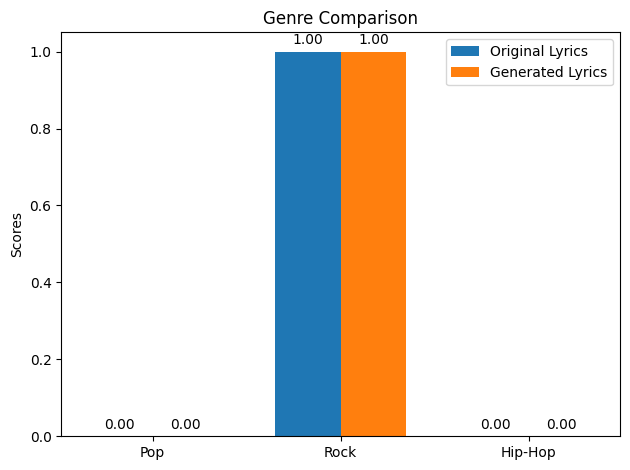

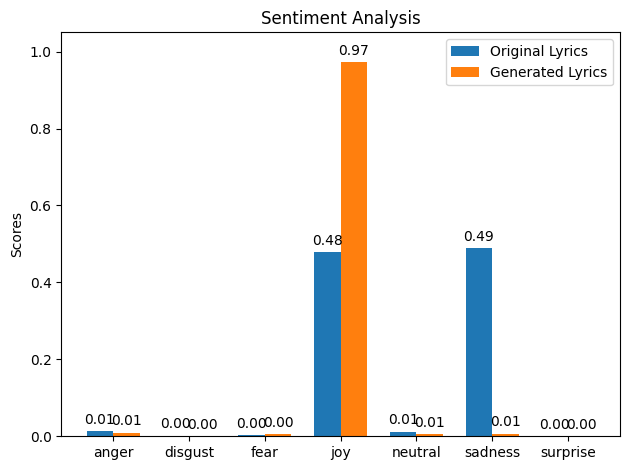

The generated lyrics for the song "Honesty" of Billy Joel:

Love look at the two of our love
Strangers in the dark
This is the end of the world
The time of the spring
The stars is calling
Are the night in the night
The day of love
A little one life
We can be a star for the last
And there of the world
You are the one dance
When you are the same
You are the perfect girl
And i can not see it
When you are not a friend
When you are a fool in a man girl
I will be a fool
And who you are coming at me
You are gonna be a fool
When you are not not you
Do you really want to know
You are never to do it
When you are not a fool
When you are coming on the stranger
You are never so much
When you are not forgotten
Why are you
You are not a fool
Who will be cool
When we are in the state
You belong
In the beginning of the cat
--------------------------------------------
The original lyrics for the song "Honesty" of Billy Joel:

If you search for tenderness
It isn't hard to find
You can have the love you n

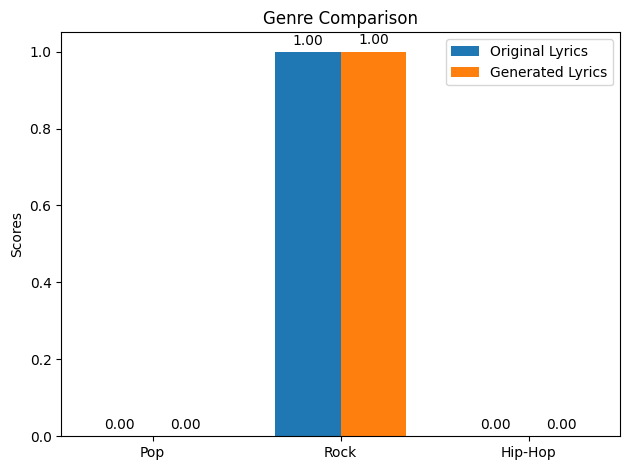

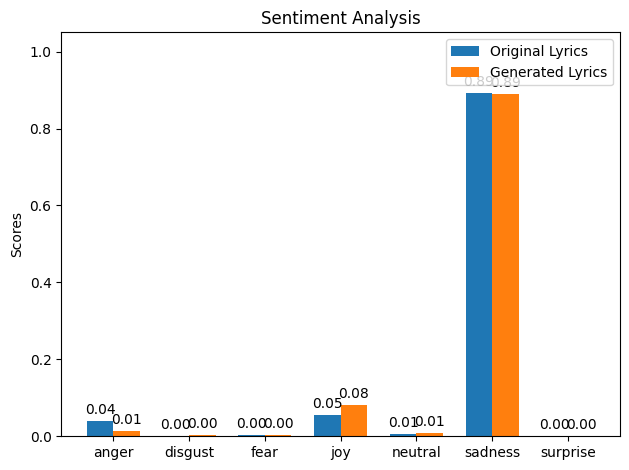

The generated lyrics for the song "Lovefool" of Cardigans:

Love of me
And you know that i am
I am a feeling of a world
And i am a fool
I was a man in a bottle
And i am thinking
For everything to say you are there a fool
I am gonna get a dream
And i am feeling
I am not gonna be strong
And i am not free to talk
I am not be a fool
I want to be your girl or you
I do not want to know why
I do not know what it is
But i have got to hear you
I would never dreamed
I will not believe it
--------------------------------------------
The original lyrics for the song "Lovefool" of Cardigans:

Dear i fear we're facing a problem
You love me no longer i know
And maybe there is nothing
That i can do to make you do
Mama tells me i shouldn't bother
That i ought to stick to another man
A man that surely deserves me
But i think you do!
So i cry i pray and i beg
Love me love me
Say that you love me
Fool me fool me
Go on and fool me
Love me love me
Pretend that you love me
Leave me leave me
Just say that you

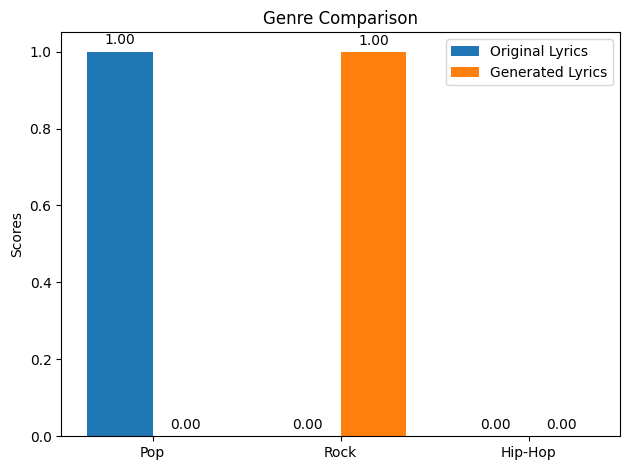

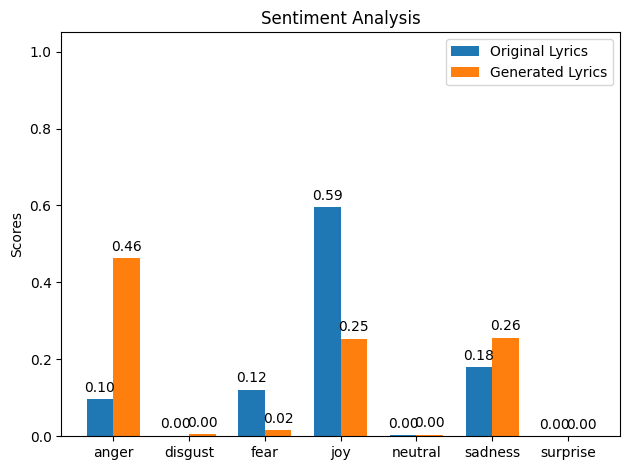

The generated lyrics for the song "Barbie Girl" of Aqua:

Love look at the way
When you are alone
I was in love
To be you are in you
And i am waiting in line
Nobody can not be afraid
When i am in my life
I am so hard to be
I am in love with you
I am waiting for a dream
And i know
I am gonna fly on
I am gonna be
I will never believe
I will always be the fool
I want you to know
I would be waiting
I am waiting to be
I will be there
I want to dance with you
I want to hold you till
I want to hear you are over
I do not want to fade
I do not want to fade
I do not want to fade away
I do not want to fade
I do not want to be your downtime
I do not want to fade
I do not want to fade away
I do not want to be
I want to be your love
Girl you are gonna be here
I will be the one
I want to be your heart
I do not want to fade away
--------------------------------------------
The original lyrics for the song "Barbie Girl" of Aqua:

Hiya barbie
Hi ken!
Do you want to go for a ride?
Sure ken
Jump in
I'm a 

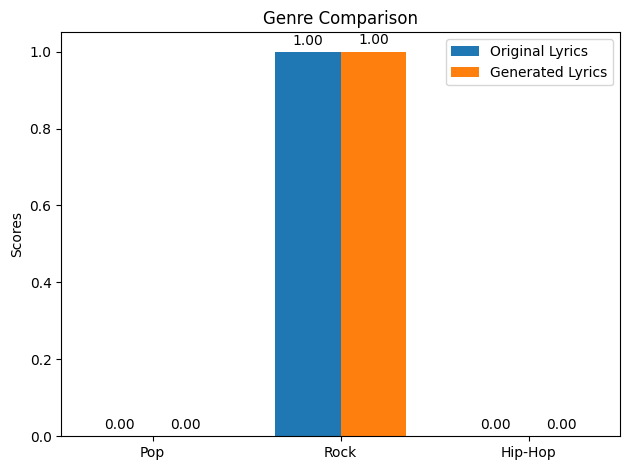

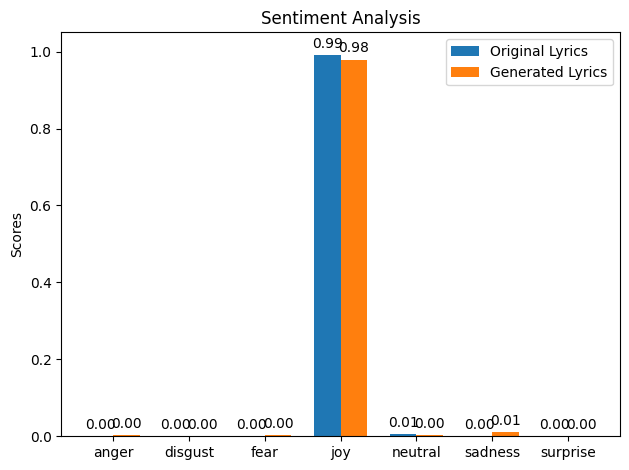

The generated lyrics for the song "All The Small Things" of Blink 182:

Love
I am a big white a new
I want to spend a little new day
I need a little lover
I want a little piece baby
I want a little piece
I want a little piece
I want a little piece
I want a little girl
I am gonna get a little
I need a little girl
I want some a white in a white
I am gonna make a little life
I will be a big tonight
I know that i am a star
I got a little girl
I am a little bit baby
I want a little boy
I want a little piece
I want a little stuff
I want a little girl
I want a little girl
I want a little girl
I want a little girl
I got a little tonight
I want a little piece lover
I know that i am not enough
When you know that i am not big
But if i ever lose
I am not if i am
But i am not not
I am gonna make it with you
I can not get back there a way
Then you are gonna make it
Cause i can not see you
--------------------------------------------
The original lyrics for the song "All The Small Things" of Blink 18

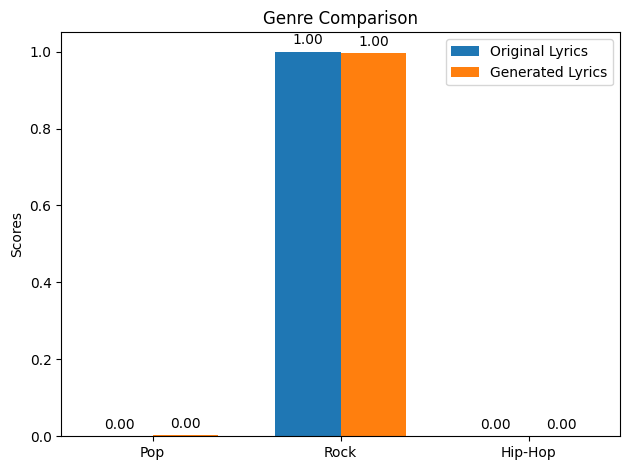

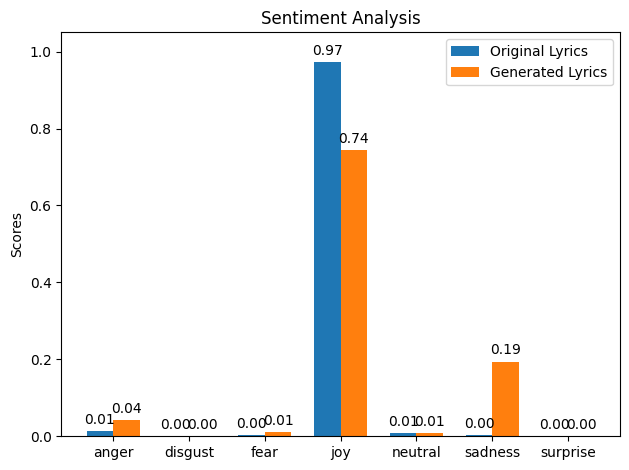

Test Scores: Cosine: 0.8532086133956909, Jaccard: 0.17230178214220768, BLEU: 2.3712138099294293
#########################################################################################
The initial word is if

The generated lyrics for the song "Eternal Flame" of The Bangles:

If you want to get your love in your heart
And i can feel it all and i do not know
I do not want to get you
You do not know you are never alone
I am so i will not believe
I do not want to fade
I am gonna be with you
I want to be your love
I do not want to fade
I do not want to fade away
I will be there to you
I want to hold you till
I want you to be
I want to hear you till
I want to you give you
I do not want to fade
I do not want to fall
I want to hear you just
I do not want to fade away
I want to be your love
I want to hear you
Do you want to do
I do not want to fade away
I do not want to fade away
I want to be your love
Girl you are gonna do me
You are all alone
Do you believe you are better off alone
Do you th

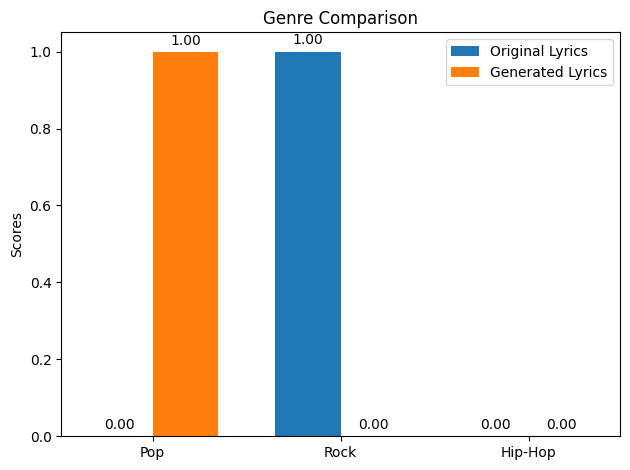

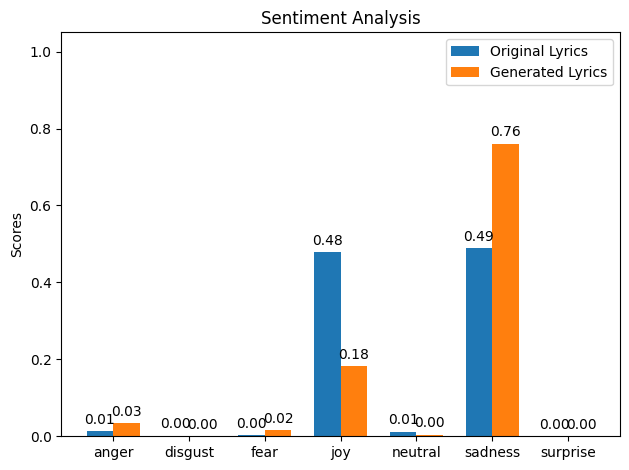

The generated lyrics for the song "Honesty" of Billy Joel:

If you want to get it to do
You have got a lot of me
You would make it take to get it
You can dust it off and try it on
It is not you just let
We think about the things that is a fool
You are never gonna get it
But you are never gonna get it
Do not you know that you are going
You are never gonna get it
But you are gonna get it
But you are better for me
Do not you know you are not a fool
Let me get around and you
Do you want to let me go
You can never let it
Open you can never leave
Cause if you go
Just a way of your heart
So can not you know
You can never let me
Cause you can take it all as try
Get around and try it on the floor
If you want to dance
Open your eyes
There is a woman
And if we are in the way
You are in love with me
And if you put your heart
And you will see you
--------------------------------------------
The original lyrics for the song "Honesty" of Billy Joel:

If you search for tenderness
It isn't hard to find

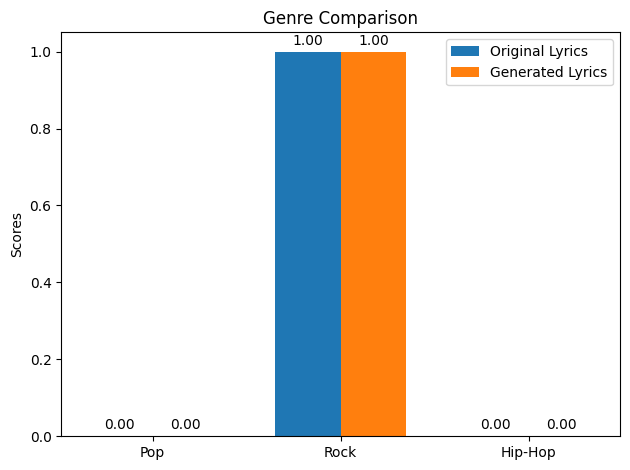

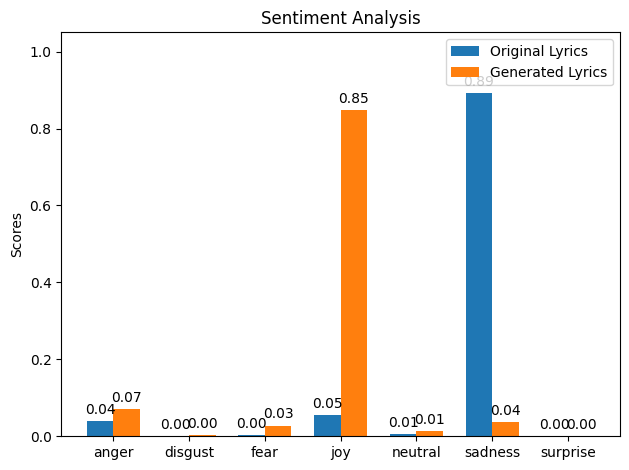

The generated lyrics for the song "Lovefool" of Cardigans:

If i have to be a fool
Cause i am a fool that i am
I am gonna find a dream
I am gonna give it all
I am a little guy
I am the one of the world
I am a man man i am a star
I am a drama in the world i am
I am gonna write a letter
I am gonna find a dream
I am a kind of my heart
I have been so much
I am gonna find a world
And no one no no one
I have got a lot of my heart
I have got a girl in the world of my mind
I am gonna find a dream
And i am a woman man no no i am gonna
I am gonna find a letter
And i am not not i know
I have been the one i have got to hear
I will not have to believe
I have got to hear no way i am sorry
But i have got a way of my heart
I had to have a lot of money money
Just to be a fool man
--------------------------------------------
The original lyrics for the song "Lovefool" of Cardigans:

Dear i fear we're facing a problem
You love me no longer i know
And maybe there is nothing
That i can do to make you do
Ma

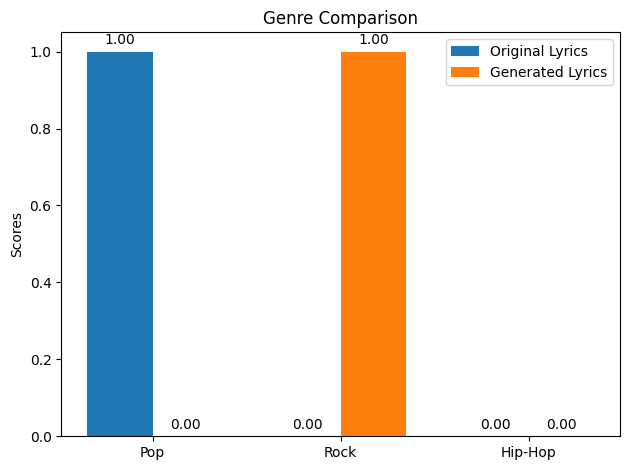

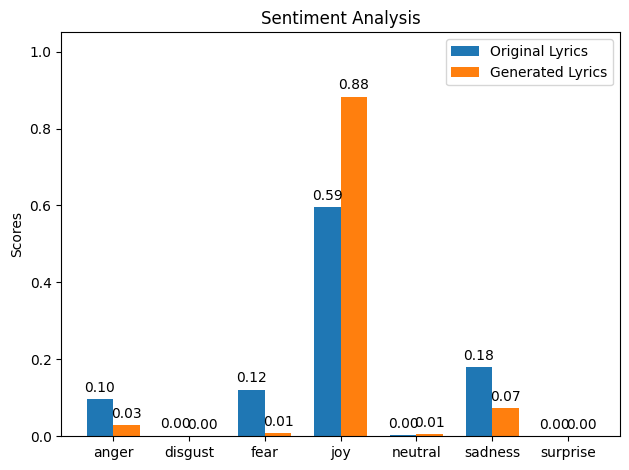

The generated lyrics for the song "Barbie Girl" of Aqua:

If you want to get it all
You are the one thing
I can not see your life
I would not find your life
I will not believe it is you
If i want to you
I will be waiting
I am just a fool
To make you happy
I want to hear you love
I want to hear you are always
I want to hold you
I want to hold you till
I want to hear you say i need you
I want to hold you till
I want to hear you till
I want to hold you down
I know i would do
I will not believe
I will be there
I am letting to dance
I will be there here
I will be there there
I will be there
I will be waiting
I am waiting in the world
When you are not far
I will be there
I will be there
I will be waiting
I will be waiting for you
I can always be with you
And if i could be right
I will always be with you
--------------------------------------------
The original lyrics for the song "Barbie Girl" of Aqua:

Hiya barbie
Hi ken!
Do you want to go for a ride?
Sure ken
Jump in
I'm a barbie girl in a

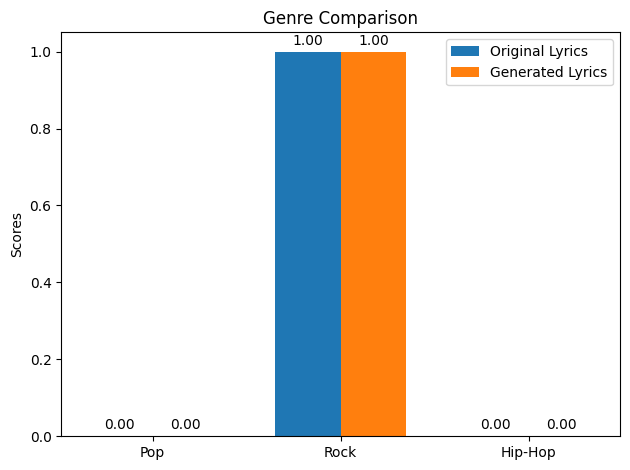

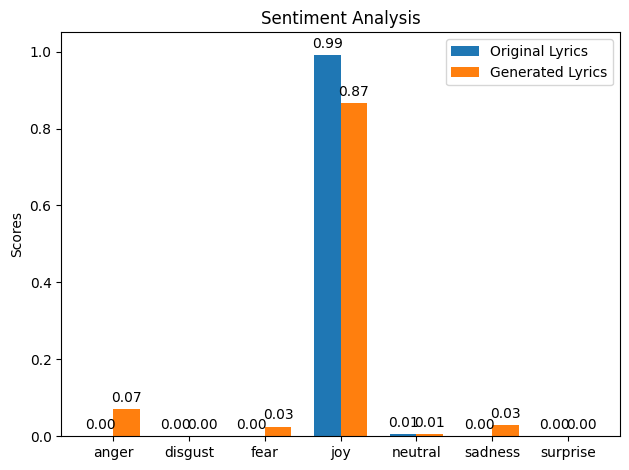

The generated lyrics for the song "All The Small Things" of Blink 182:

If i am a bit in in the park
I know i was gonna wear it
I am gonna get it on the day
I am gonna use a shower tonight
I got a little big stuff and i got
I got a little white guy
I got a little big drink
I got a little in a white in the park
I am a man in a white
I kissed her and the queen of a
And i knew that mable a smile
I kissed her flowers like a mom
And i am a little white
And i got a little white
And i got a little boy
I bought a little one
I bought her flowers with a hero
I bought a little white
And i am pins on the tv
And i will never be with
I want to be a friend
She said that she was not
She is gotta be a friend
She is got a way to believe
She said that the way to do to know
He was gotta be a friend
She is got a way before
The days that i do
I saw the law and the law won
--------------------------------------------
The original lyrics for the song "All The Small Things" of Blink 182:

All the small things


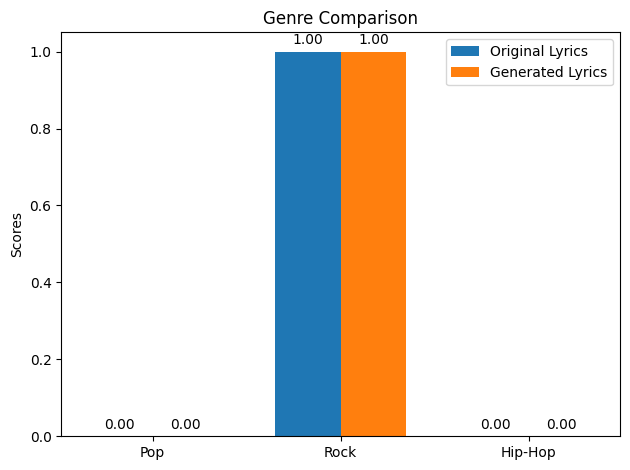

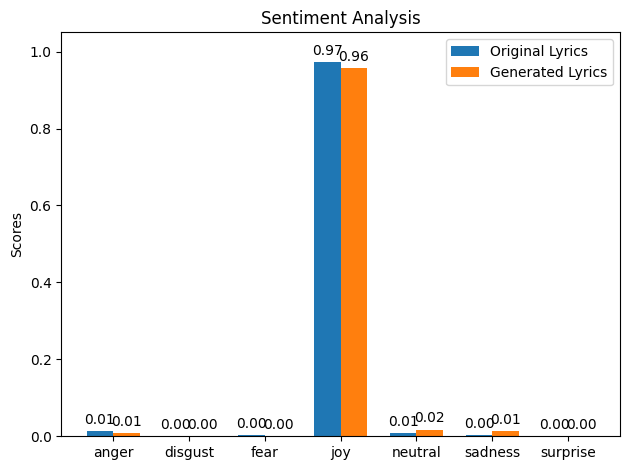

Test Scores: Cosine: 0.848600423336029, Jaccard: 0.19187461248502347, BLEU: 2.584577046187298
#########################################################################################
The initial word is what

The generated lyrics for the song "Eternal Flame" of The Bangles:

What kind of those lonely
You are my man
And i guess you could be right
I do not want to be your downtime
I just want to be
I do not want to fall you
I do you you to be
I do not want to fall you are
I will be a fool
I want to hear you till
I do not want to be you
I do not want to fall
I am gonna be with you
And i will take you all
I want to hear you till
I want to hear you
I do not want to fall away
You make me all
And i will be there
I want to dance with you
I do not want to fade away
I want to be your love
I want to hear you
Do you want to do
I do not want to fade away
I do not want to fade away
I want to be your love
Girl you are gonna do me
You are all alone
Do you believe you are better off alone
Do you think

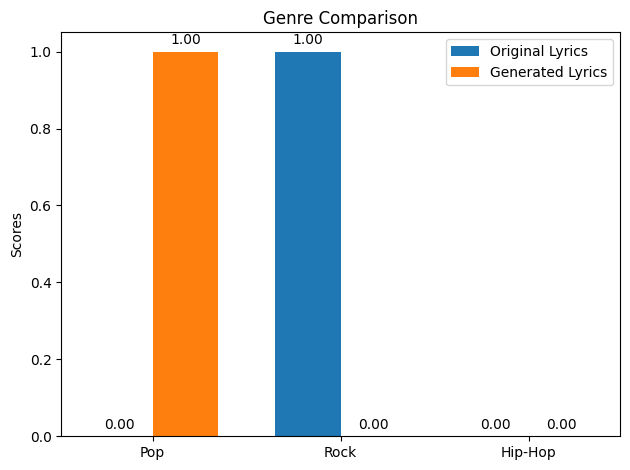

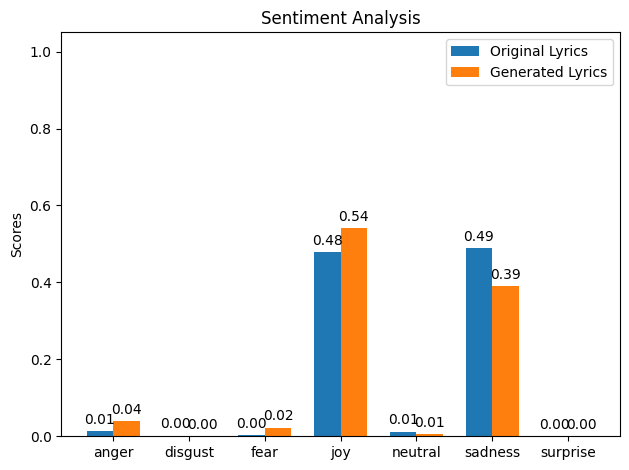

The generated lyrics for the song "Honesty" of Billy Joel:

What kind of those lonely life
When i have been there gonna be
I am in love with you
And i am thinking you are gonna go
I am in love
I am sorry that you are mine
I am not you are believing
You are no one
Who caught me in the way
You are my voice
You gave me high
To make you happy
And i am in your eyes
I drove in night
Crept out
You are my obsession
Who was a quiet thing to hide
I am in love with me
I am a girl in you are all
And i see you could not see
I am not a fool
You are just
You are my obsession
I bought my soul
Who you are mine
I am a vision
You are always for me
And i am not a fool
Was not a problem it is been hard to hurt
I am feeling in you
I am blessed
For breaking your heart
And i am your eyes
Now i am your eyes
--------------------------------------------
The original lyrics for the song "Honesty" of Billy Joel:

If you search for tenderness
It isn't hard to find
You can have the love you need to live
But if you l

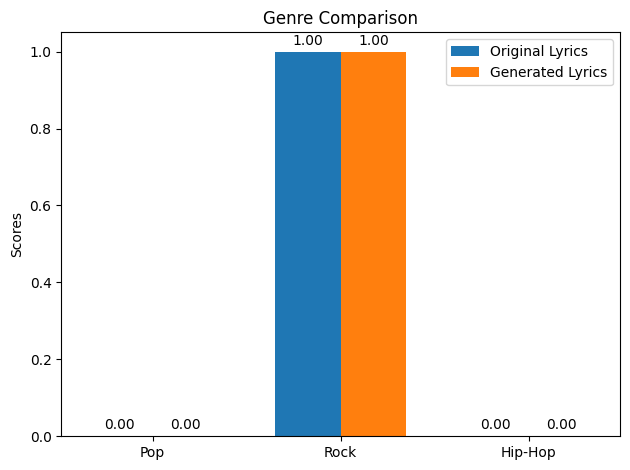

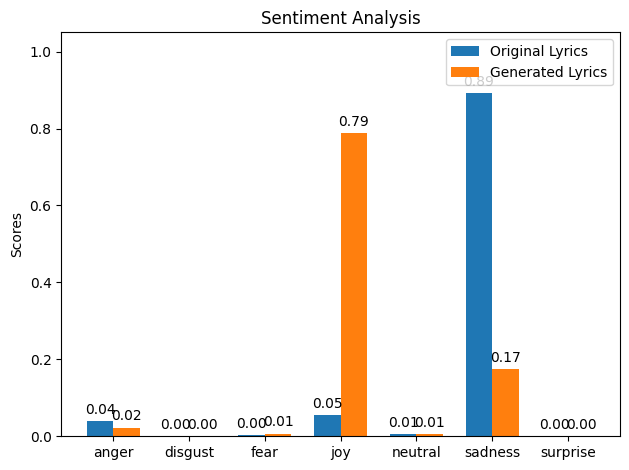

The generated lyrics for the song "Lovefool" of Cardigans:

What is the end
It is hard to be a single boy
Who will be a star
Who will never make it
The way of a million time
And it is a little place
It will never be afraid
But will never give you
He is gonna buy to get to
And it is not be long
And the old is changing
And it is getting hard to get
And they are living at the pool
And if you ever lose it all
And i have been waiting for a new time
With the pillow oh oh oh oh
It is the one of the world
And he is a girl
Oh oh
It is the one
I am in the money
The boy is a
Money about a heart
And a little heart man
It is a cruel man
She is a cruel cruel cruel cruel
Leaving on the street
I know it is a good
But i am not a good fool
But i am picking down the street it is
She is a brick and i am drowning slowly
Off the coast and i am headed nowhere
She is just a good man
I am gonna make her you the same
With a man or a star
A new man that was loved
She is just a way of friends
She is got a kid tha

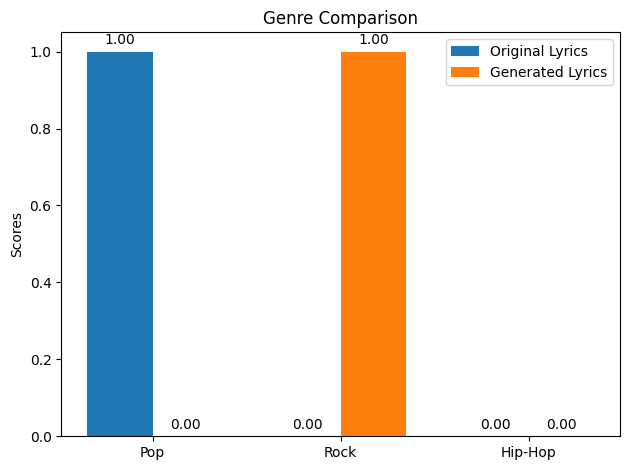

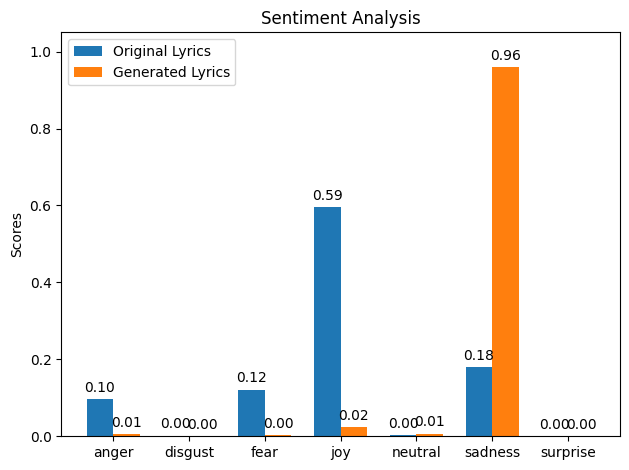

The generated lyrics for the song "Barbie Girl" of Aqua:

What kind of those life
I would be a fool
I am a woman lover
I am a ribbon bad
I am waiting in a summer
With a world as we can not see
The time is the end
And i was found you
And i was living in the world
I would be a fool
But i was not a fool
To be a fool
I am waiting in a new
I know i was loved
I was a woman
I was born a dream
And i was waiting in the world
I would never be afraid
If i was afraid
I was waiting to get a place
And i was a woman
I was high in the city
I would hear the world
But i have been waiting here
I have got a way
To meet a world
I have been waiting for a dream
That i have got a little
And i had to go
She is a brick
I have got a thousand man
Then i am holding on
If i am the one
Who i am inside
For a child
For a friend that a child
And a brother that a friend
A new one of mine
That i can not see the world
I am a woman in my life
I will never reach
The world of her places
And i have got a hero
And i am not big

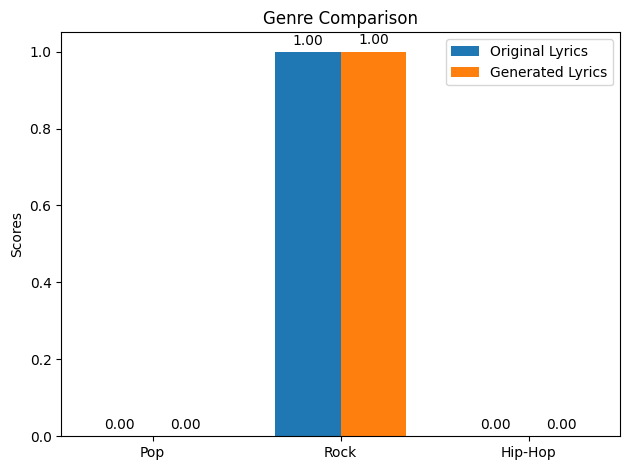

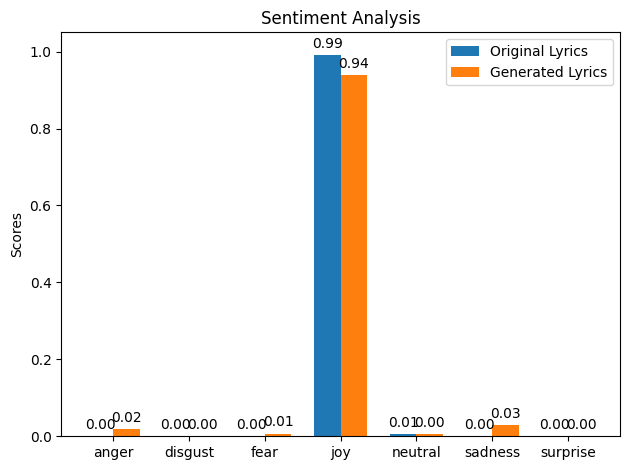

The generated lyrics for the song "All The Small Things" of Blink 182:

What i am feeling
I was waiting to a bad
I am in your side
I am just a secret white
I am just a little white
I am a little white
I am a little white
I am gotta to get it
I am a little white
I am some alone
I am a young
I am just so fine
I am not a call in a white gun
I am a man in a white
I kissed her a whore
I bought my head like i am weak
She is not easy to get to me
I am a man in a white
I am gonna get a fella
And i got nobody that i am lost
I am my head
I am so a bad new
I am not she
I am alone in a while
I am a drama man in my eye
I am going back in a world
When i am all with you
She is out my way
I am so living up
I am waiting in line
I am just a kid
She is got a way of telling
I am telling you
I am going in a white
I am alone
I am a eye in a white man
I am a new york state
I am gonna find a ride on my own
I am gonna make it
--------------------------------------------
The original lyrics for the song "All Th

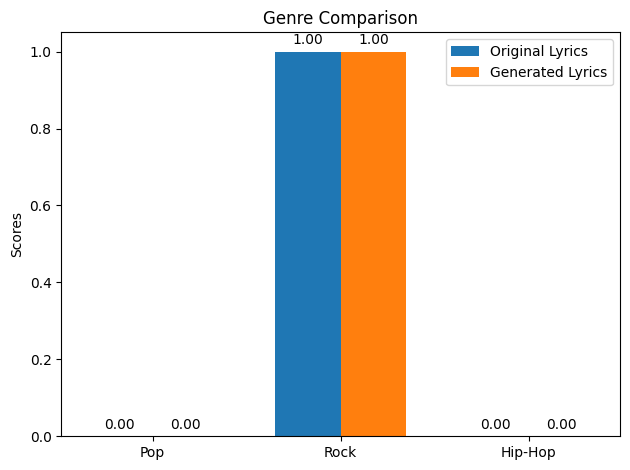

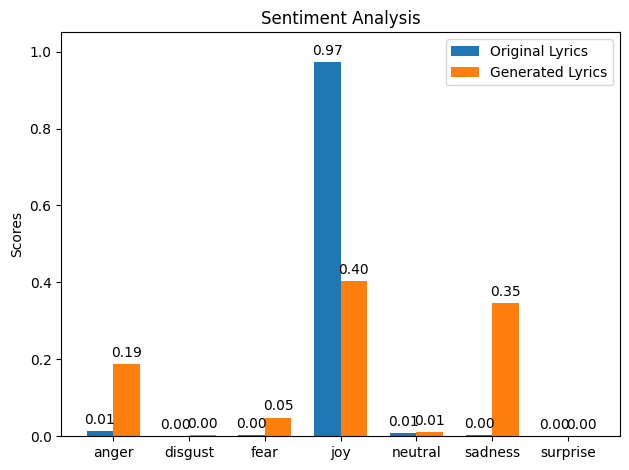

Test Scores: Cosine: 0.8199343204498291, Jaccard: 0.1710295336880218, BLEU: 2.5702098108701765
#########################################################################################


In [33]:
args['midi_features_type'] = 'melody'
args['frames_per_word'] = 1
music_features_dim = get_dim_by_type(args['midi_features_type'])

configuration_name = f"midi_features_type_{args['midi_features_type']}_frames_per_word_{args['frames_per_word']}_lr_{args['lr']}_dropout_{args['dropout']}_num_layers_{args['num_layers']}_weight_of_lines_{args['weight_of_lines']}"
model_name = f"model_epoch_{args['epoch']}_{configuration_name}.pth"
# print(f"Loading with the configuration:{model_name}")

test_dataset = LyricsMelodyDataset(test_lyrics_df, midi_files_path, args['frames_per_word'], midi_features_type=args['midi_features_type'], avg_duration_of_word=avg_duration_of_word)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# load the best model from the disk from here f'models/best_model_lr_{lr}_dropout_{dropout}_weight_of_lines{weight_of_lines}.pth'
model = LyricsGenerator(embedding_dim, music_features_dim * args['frames_per_word'], hidden_dim, output_dim, num_layers=args['num_layers'], dropout=args['dropout'])
model.load_state_dict(torch.load(model_name))
model.to(device)

result_per_word = {}
for word in initial_words:
  result_per_word[word] = test(model, test_dataloader, word)

results[configuration_name] = result_per_word

# Test - Approach 1 (Only Melody Features, frames per word: 10)

The initial word is love

The generated lyrics for the song "Eternal Flame" of The Bangles:

Love look at me
I was a my
So baby
There gimme i i to to
I i not to to
To you not to to to
So you you to
You you you to
I you
I you time to
You you you you to
You you you to to
You you look to you
You you you you
You you you you
You you you
I you you
I would to
And you you
I would you to
And you the
And love my
And to to
And i the
And me
I to to
And the
And to the
I the to
And you to to
You to
You you to
You you to
I to to
I you to
To to to
Only love to
I you to
To to to
You you to
To do to to
To to to to
To to to
Only only only thing to
I do to
To you not
You you you not
To to your heart
--------------------------------------------
The original lyrics for the song "Eternal Flame" of The Bangles:

Close your eyes give me your hand darling
Do you feel my heart beating
Do you understand
Do you feel the same
Am i only dreaming
Is this burning an eternal flame
I believe it's meant to be darling
I w

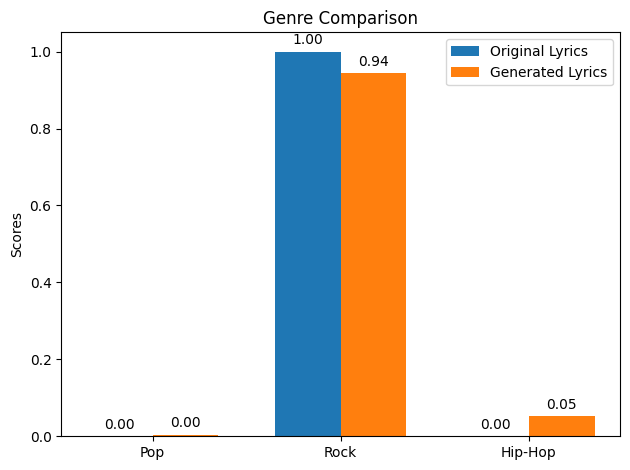

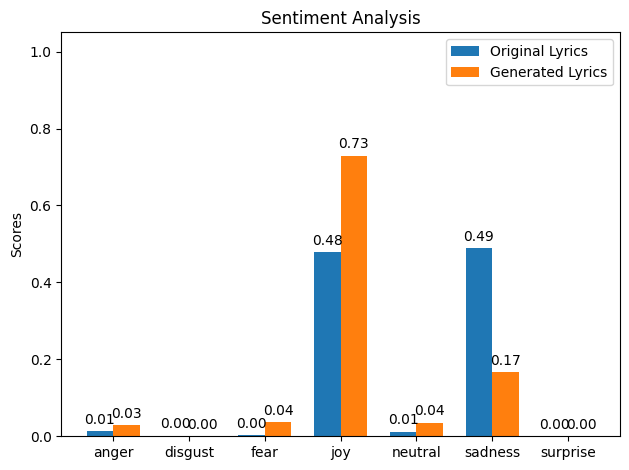

The generated lyrics for the song "Honesty" of Billy Joel:

Love look at me time
I not not to to
And we all that
And the of of of
And dreams dreams on
And the the
And the the the
And into the the
The the the the
On
On you and
And needed
And i
You you
And
That the
And
I you you you
And you
We want to
And i want to you
And you you you
I you to to
You you you to
You you you you you you
You you you to
You you to you
I you want to to
I you you to
And i you
And you to to to
You i you to
I you you
And you you to to to
And you you to to
And you to
And close close to
You you to to to
I i to
I i not to
And you to to
I you to to
And you to to
And your to to
I you you to
You you you to
I you to you
I you to to
I you you
I you
And you
I will to to
I will you to
I you you to your
--------------------------------------------
The original lyrics for the song "Honesty" of Billy Joel:

If you search for tenderness
It isn't hard to find
You can have the love you need to live
But if you look for truthfuln

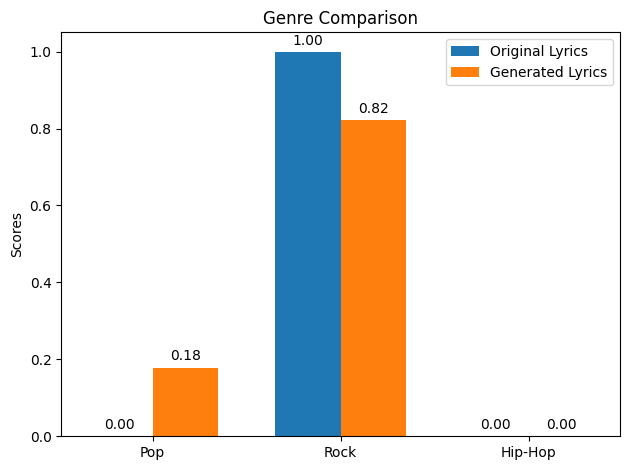

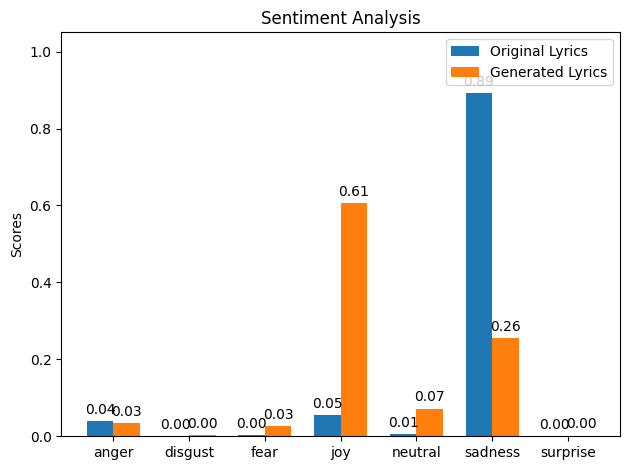

The generated lyrics for the song "Lovefool" of Cardigans:

Love
It is the and is and to
And the the
And i not i to to
And little the
And and i say to say
And the the
And a
And the
And the the
A a
And it the
And a a
And is is a a a
And is a a night
I i my a my
And and that hard that a is
And at is little my
And little little little
Ooh little my little little little at
I am a and and
I i i am to i i am
I i little a a
And is little a
And i am is is
I i need need
I i is
I am not not
I i not
I am is a
I am not am
I i not not me
I am not a little
Just you me a on
I at little me
I a a little on
I on my on
I am little at at
I am am my my
I am me to my
I i am my my my
I i my my to to
I i am to to to to
I i not to to i to to to to
I i love to be
--------------------------------------------
The original lyrics for the song "Lovefool" of Cardigans:

Dear i fear we're facing a problem
You love me no longer i know
And maybe there is nothing
That i can do to make you do
Mama tells me i shouldn't bo

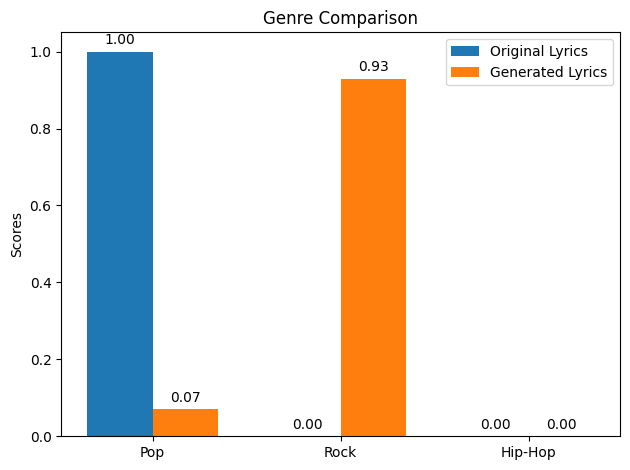

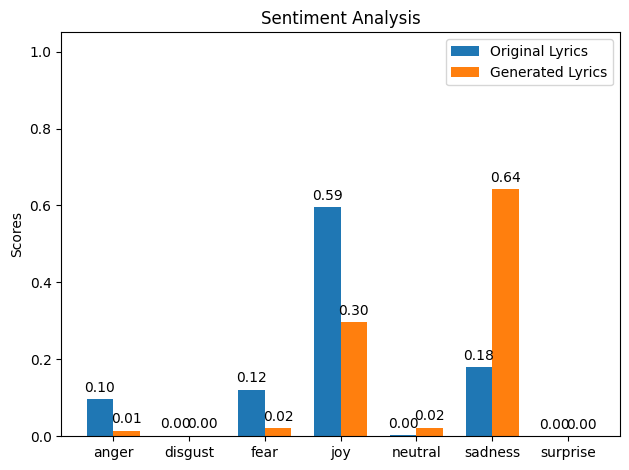

The generated lyrics for the song "Barbie Girl" of Aqua:

Love look at me
The
I you you love
I you you say
What you you you
I i you you
I i i the
You i i you
And the i
I you you
I could i the the
I could i what
What could the
I i the
I could i
I could you
I i to to
I could to to to
What could matter
I could matter
I was matter could
What could matter could
What could matter what
What could what
Could could could to
I could i could
I could could
I could the
I could to to to
I to to
So the to
So the to
I the to
I you you could could could
I could be to to
I could you you be
You would be be
With me be be
With me be be
With with be to
I will be to be
With you be be be
I i could you be
I i be be
I i be be
I my you
I you you be be
You you be be
You you be you
You you be be be
You you be be be
I me me to be my heart
With a world
--------------------------------------------
The original lyrics for the song "Barbie Girl" of Aqua:

Hiya barbie
Hi ken!
Do you want to go for a ride?
Sure ken
Jump 

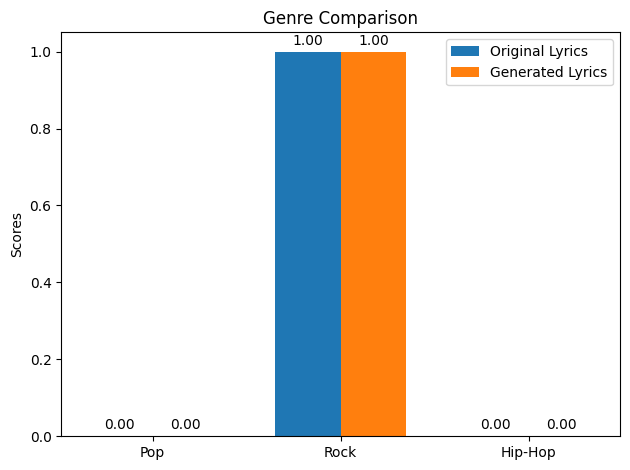

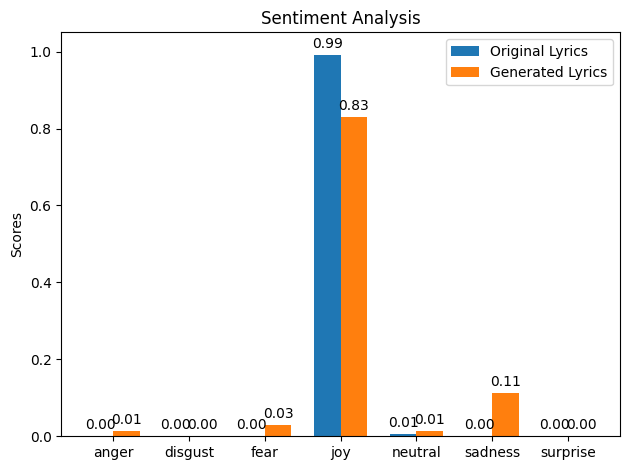

The generated lyrics for the song "All The Small Things" of Blink 182:

Love look at the the the
And a a a
The the the the
Looking a a to
Since baby a
And the some
And on a
I the some baby
And the the the
I i the
I the the
I i the
And the the
I the the the
And the the the
And the the
And on a
And on
And the the
Baby baby
And the the
I baby hand
And baby on
And baby some
Baby baby the
And baby my baby
And the the
I
I the the the the
And and the
And the
And a the
Some
Some the
I the the
And
And the the
Baby some show
And the the
Baby baby show
And the
Baby baby the
And the the
And the the
And
I i be to the
And the
And the and the
And the the the
And the the the
And the the
And the the
And baby how you do not you
--------------------------------------------
The original lyrics for the song "All The Small Things" of Blink 182:

All the small things
True care truth brings
I'll take one lift
Your ride best trip
Always i know
You'll be at my show
Watching waiting commiserating
Say it ain't so

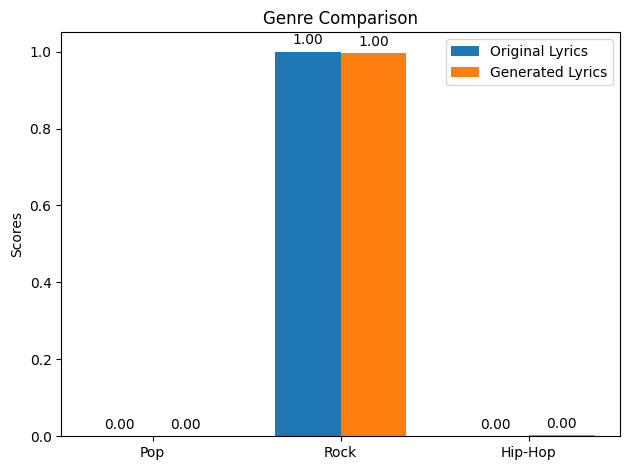

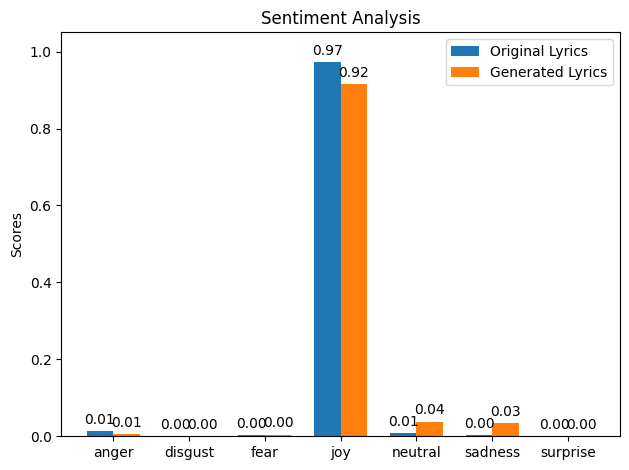

Test Scores: Cosine: 0.673951268196106, Jaccard: 0.15576280100854362, BLEU: 1.5431100274438607
#########################################################################################
The initial word is if

The generated lyrics for the song "Eternal Flame" of The Bangles:

If you want to leave
I would you want about
It you wanna to you you
I would would you you you you
I would would you to you
I you you you you
I would you you
I would you you you you
You you you you you you you you you you you you you you you you you you you you you you you you
You you were you
And you would you you
You you you you you
You would you you
And you you you you
I would would you you
I you would you you
I you you you you you you
I would would you
And you you me
I you would to
You you you you
You you would you you
You you you you you you
You you you you you you
You you you you
You you you you you you
You you you you you you you you you you you you you you you you you you you you you you you
You you you you 

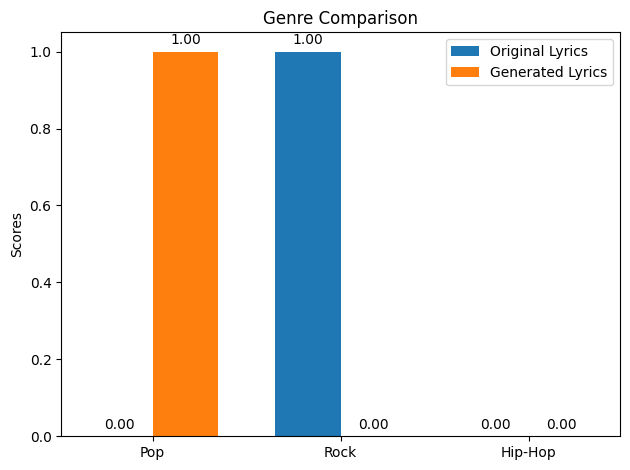

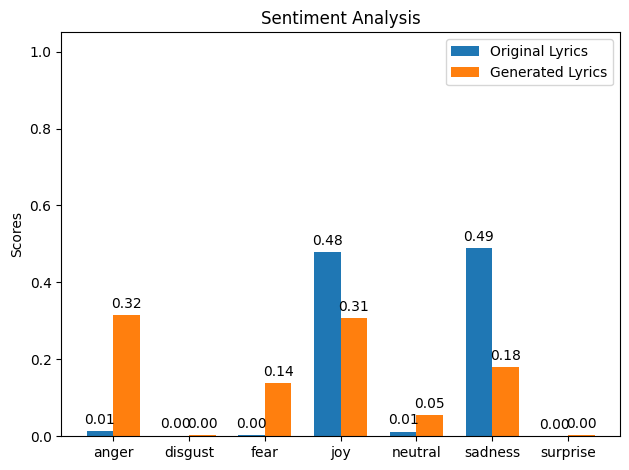

The generated lyrics for the song "Honesty" of Billy Joel:

If you want to way
I not not not to to to
I i want to you
I you you to to to
And you you to to
You you you to a you
I you a a you
I you have to you
I you to you
I you do to to
You have a to
I you you you you
I you you to to
I you you you you you
And you you you you
And you you you you you you
You you you to you you
I you you to to
You you to you
I you have to to
You you you to
I you you to you
You you you you to
I you to you
You you you you
I i to to you
You you you you to
And you you you
You you you you you
And you you you to
I you you you
I you you to to to
And i you to to
I you to to
You you do to you
I you you you you
I you you you to
You you you to
You you not not to
I you you to
And your i to you
I you do you you you
I am to love
--------------------------------------------
The original lyrics for the song "Honesty" of Billy Joel:

If you search for tenderness
It isn't hard to find
You can have the love you need to live


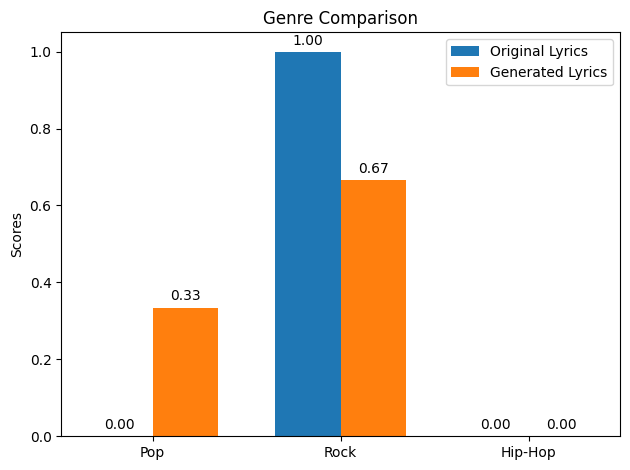

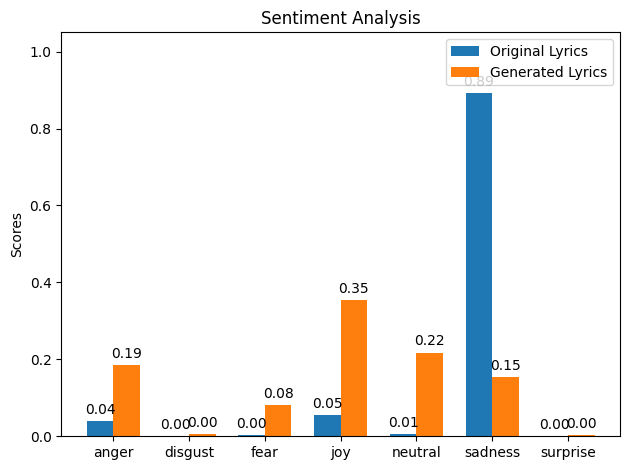

The generated lyrics for the song "Lovefool" of Cardigans:

If
It is is and is and to
And the the
And i not i to to
And little the
And and i say to say
And the the
And a
And the
And is a
A a
And it the a
And is a a
And the a a
And the the little
And i my am to to
And little that hard and a
And little little little
I is little little
I i i little little i little little to
I am a to
I i not not to
I i not got to
My my my
I am need need
And i am i i i
I i need need
And is
I am not not
I can
I am is
And i am am a my
I i not not me my
I am am little me
I me me me me
Oh me me
I is a little
On me me me
Just me me me
And me me me me me
I am me me me me
I i am my my
Ooh i me me
I am am me me
I am my my
I i am my to i i my love girl
I i my to me
--------------------------------------------
The original lyrics for the song "Lovefool" of Cardigans:

Dear i fear we're facing a problem
You love me no longer i know
And maybe there is nothing
That i can do to make you do
Mama tells me i shouldn't both

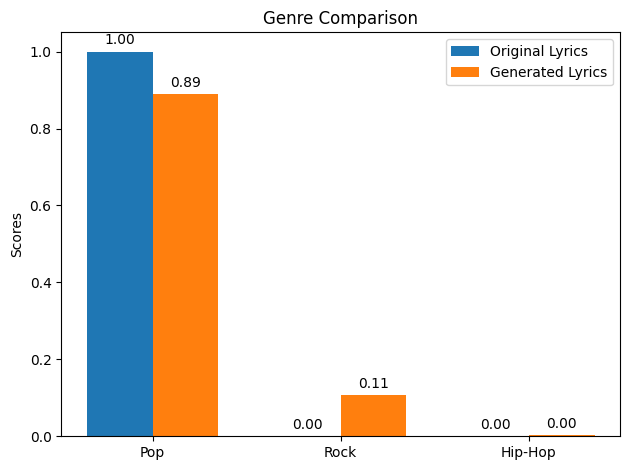

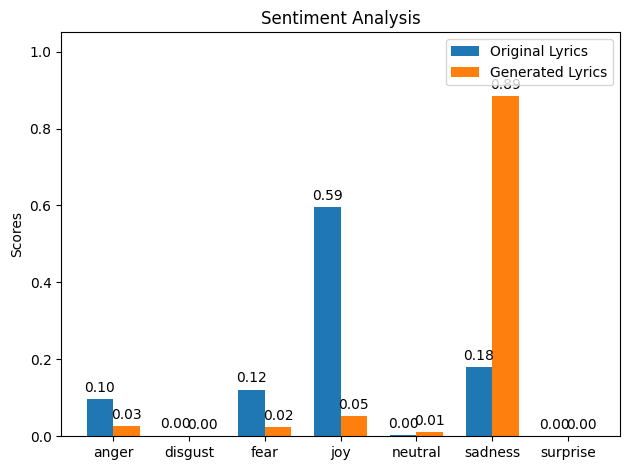

The generated lyrics for the song "Barbie Girl" of Aqua:

If you want to leave to
It you not not to to
It you you it you
You you you you
It is you it
So is are a
You you i you you to
I i you you out
I i i to to
I i i to you
I i to to it
I i i to to
I i i i
I i i to to
I i was to to
I i i to it to
I i i do do to to
So i i to
I could you to to to
I i could you you
I you to to
I could you to to to
I a i
I i i to
I i a a
I i be to
I i i
I i be
I i i you
I would be
So you to you
So you to to
So you be to to
I i to be to
I i i to
I a a
I i i you you
I i be be
I i i be
I a i
I i i be to
You you be be to
I i be be you
I i be be
I i be be to
I i be be be to be the way with you
--------------------------------------------
The original lyrics for the song "Barbie Girl" of Aqua:

Hiya barbie
Hi ken!
Do you want to go for a ride?
Sure ken
Jump in
I'm a barbie girl in a barbie world
Life in plastic it's fantastic
You can brush my hair undress me everywhere
Imagination life is your creation
Come on b

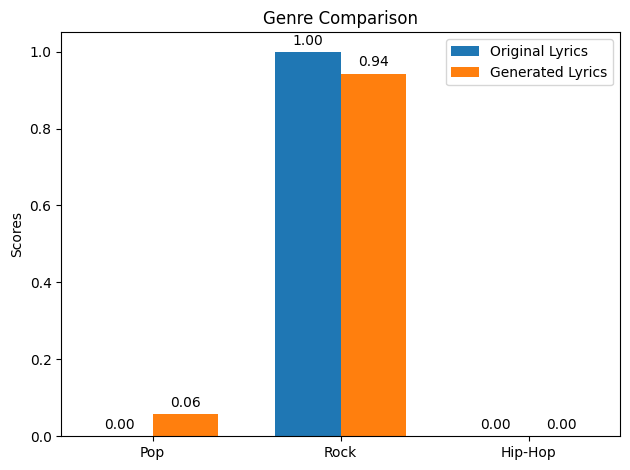

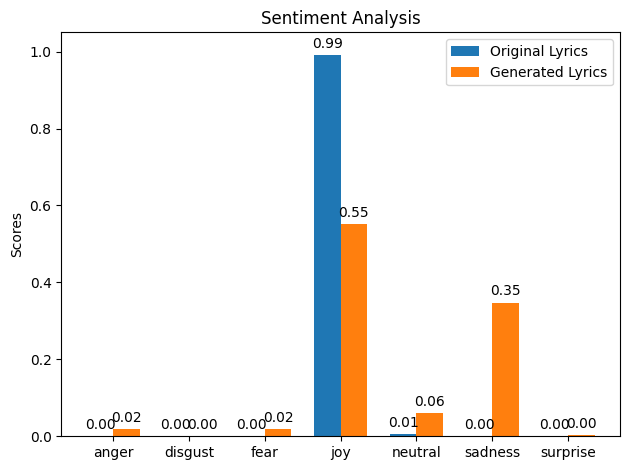

The generated lyrics for the song "All The Small Things" of Blink 182:

If you a to to to
You a a
And to to
If i a a
I i you you
I would a to
I you have to
I i to
I you i
I have to
You it it
They i the
I i i
I i wish you
I i you
And you you you
I you you and
I you you
I you you
Cause and
And the again
And you again again
And i you
And i
I you i you again
And you you
I can you
I i the
I the the
And i the
And you a
Cause if show show
I you show
And show
And and you
And show show
And you and
And show
And the the
And the
And you
And you me
And the the
And you the
And show show show
And the and
And you show
And the and
And and you
Cause i show
Cause you
--------------------------------------------
The original lyrics for the song "All The Small Things" of Blink 182:

All the small things
True care truth brings
I'll take one lift
Your ride best trip
Always i know
You'll be at my show
Watching waiting commiserating
Say it ain't so i will not go
Turn the lights off carry me home
Na na na na
Na

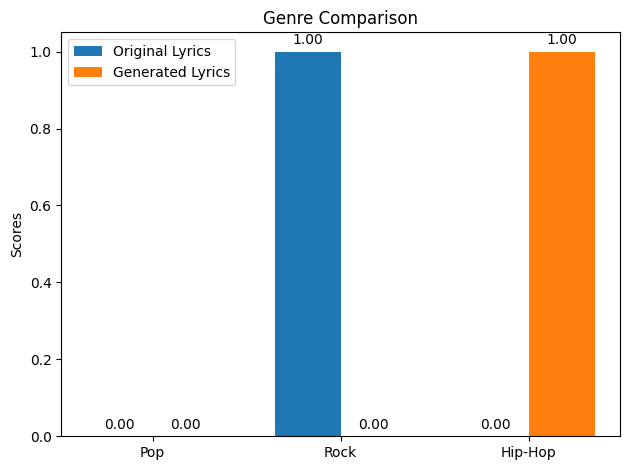

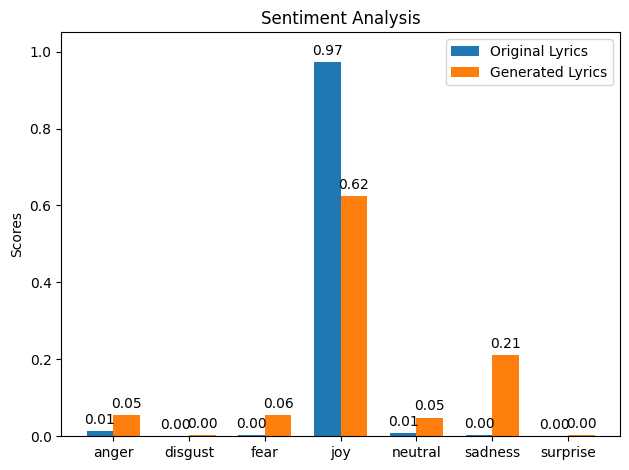

Test Scores: Cosine: 0.6901657700538635, Jaccard: 0.13457808994244463, BLEU: 1.6261531230686053
#########################################################################################
The initial word is what

The generated lyrics for the song "Eternal Flame" of The Bangles:

What is a tequila story
And get on on
In
And down the to
And to to
But the to to
But the
A a a a
And you the the
Thumping a a
Something a a something a two of
The a of out out
And the the to a in of of
The the the
She the the of cat
And the her out the the
The the the the the the
And the the
The the the the
And the the the
The the the the
And the the the the
And the the
Is the the the
The the the the the the the
And is the the the
The the the
And you not that you
You you not like the the
That the the like the
The the the the the
The the the the
And the the
And the the the
And like like
The the the
And like the
And the the the
And the
And the of
And the the the
No the new of of
-----------------------------------

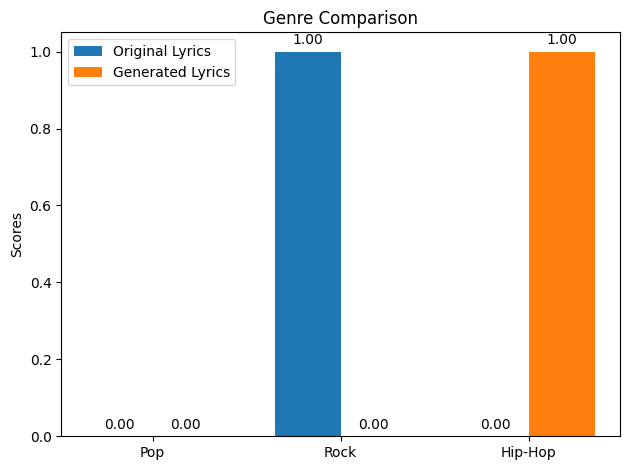

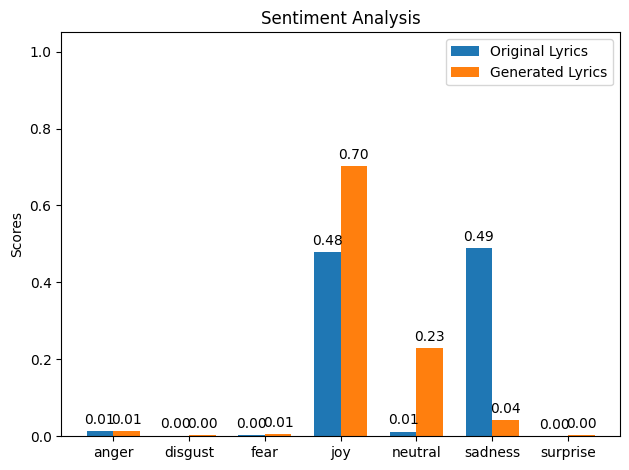

The generated lyrics for the song "Honesty" of Billy Joel:

What is a tequila in
And the a a the
And i a
And a a a a a
And a a a
And in the time
And a a a a a
And a a a a
And a a a i i not not
And i i a a
And is have have his
And i i not i
And his i is is the the
And the they the the
And is a are
And is a a
And they guess not to
And
Just think think they they are are are
And you are you are them
And is the at are
And the are are
And i are the
And we think not are
And the the
And we the the
And are are to to
And the the the the
And the the
And the
And the
And i are i i not
And the not the
And i are
And you are is
And are not
And is is
And you not not to
And you not have are
And and a
And is the are
And are are are are are
And you are are are
And we are
And are not the
And i not is is
--------------------------------------------
The original lyrics for the song "Honesty" of Billy Joel:

If you search for tenderness
It isn't hard to find
You can have the love you need to live
But if you l

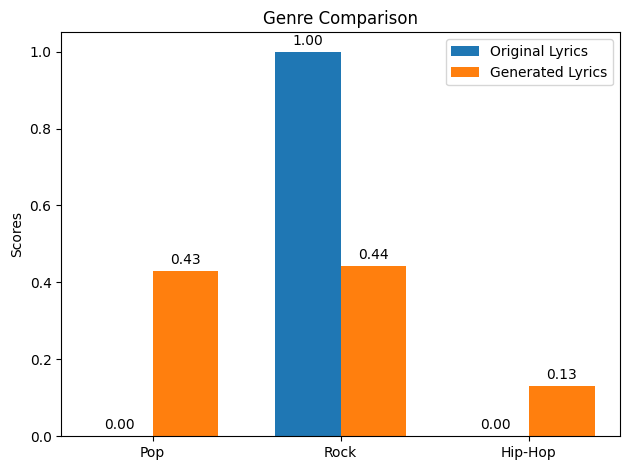

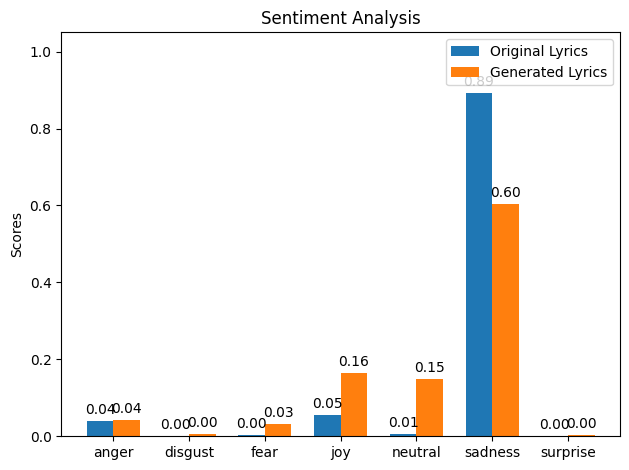

The generated lyrics for the song "Lovefool" of Cardigans:

What
It is is and is and to
And the the
And i not i to to
And little the
And and i say to say
And the the
And a
And the
And is a
A a
And it the a
And is a a
And the a a
And the the little
And i my am to to
And little that hard and a
And little little little
I is little little
I i i little little i little little to
I am a to
I i not not to
I i not got to
My my my
I am need need
And i am i i i
I i need need
And is
I am not not
I can
I am is
And i am am a my
I i not not me my
I am am little me
I me me me me
Oh me me
I is a little
On me me me
Just me me me
And me me me me me
I am me me me me
I i am my my
Ooh i me me
I am am me me
I am my my
I i am my to i i my love girl
I i my to me
--------------------------------------------
The original lyrics for the song "Lovefool" of Cardigans:

Dear i fear we're facing a problem
You love me no longer i know
And maybe there is nothing
That i can do to make you do
Mama tells me i shouldn't bo

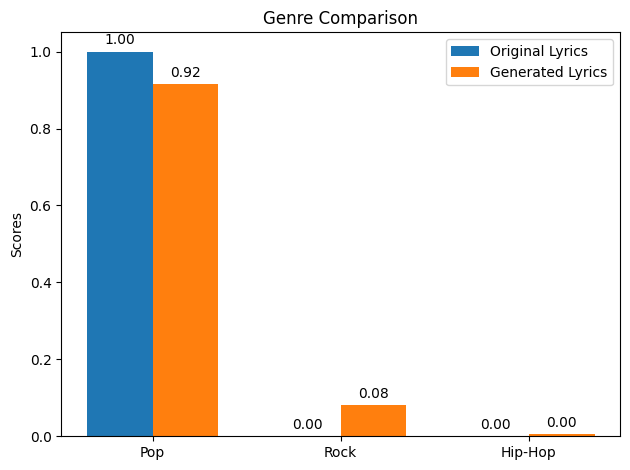

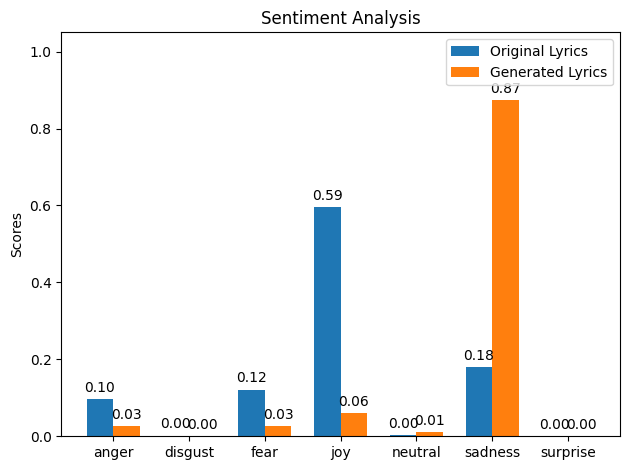

The generated lyrics for the song "Barbie Girl" of Aqua:

What is a tequila story of a
And a a and and and with and and
But a man
And with heard with
And another the with
They the the the the
They the the the
She the the the
And is the
There the there
And is their
She is is to
I is is long you long to
So is is is is long long
So a living so
So a living here so
So was living so so
So is been long
So living a it living here
So a a a a long
So a a a with
And a a in a
And a in a for
For a a a
So a a
For a for
Just a a
For a a
And a a for
For a a a
And a a for
So a a
So a for for
So a a
Just a a for
For a a
For for too
For a for
It a for for
So a a
It a for
For a a
For a a the
For a a a
Just i a a
Just i a a
Just is a a for
And the the a
And is a way in for
And i have got on the way
Who you the wants
A a mountain day
--------------------------------------------
The original lyrics for the song "Barbie Girl" of Aqua:

Hiya barbie
Hi ken!
Do you want to go for a ride?
Sure ken
Jump in
I'm a b

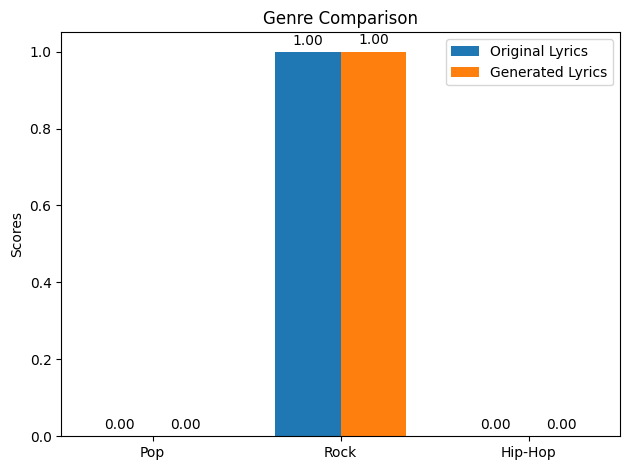

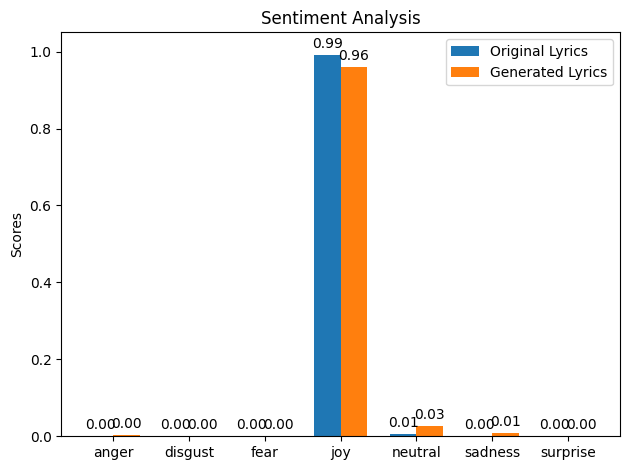

The generated lyrics for the song "All The Small Things" of Blink 182:

What is the night all
And the the your
And you to
And the
And i i
How i a a
I on
And i the
And i the
I i the the
I have the
And the the the
I do the
And do the
And i the to
I the love
And the the
And the on
And show on
And the the the
And the the
And the the the the
And the and
And the the
And you you
And you the show
And the the
I you the show
You the the
And the the the
And the the
And on the
And you
And the show and
And and you
And on show
And you and
I on show
And a
I i to
And you the
And on the you
I i looked me
I to to to
I i and to to
I you my and
And on a a
And i the i i
--------------------------------------------
The original lyrics for the song "All The Small Things" of Blink 182:

All the small things
True care truth brings
I'll take one lift
Your ride best trip
Always i know
You'll be at my show
Watching waiting commiserating
Say it ain't so i will not go
Turn the lights off carry me home
Na na na na
N

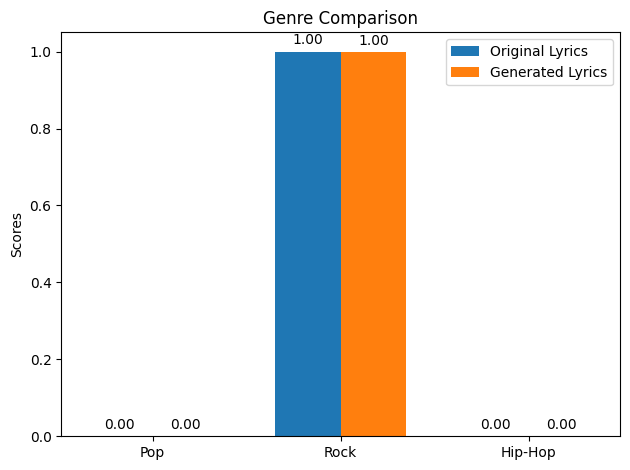

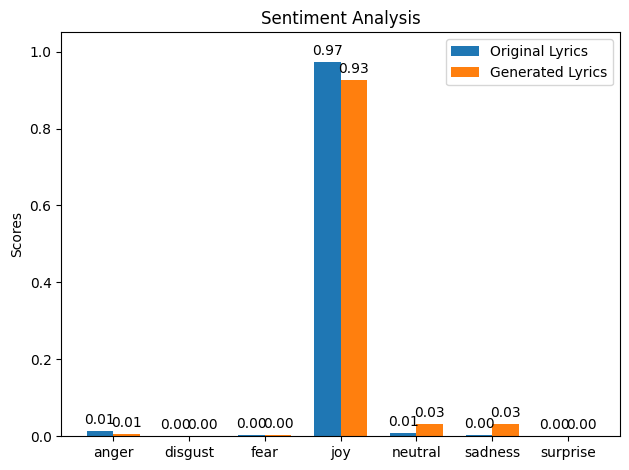

Test Scores: Cosine: 0.6322353959083558, Jaccard: 0.13945176666523093, BLEU: 1.267751950947165
#########################################################################################


In [34]:
args['midi_features_type'] = 'melody'
args['frames_per_word'] = 10
music_features_dim = get_dim_by_type(args['midi_features_type'])

configuration_name = f"midi_features_type_{args['midi_features_type']}_frames_per_word_{args['frames_per_word']}_lr_{args['lr']}_dropout_{args['dropout']}_num_layers_{args['num_layers']}_weight_of_lines_{args['weight_of_lines']}"
model_name = f"model_epoch_{args['epoch']}_{configuration_name}.pth"
# print(f"Loading with the configuration:{model_name}")

test_dataset = LyricsMelodyDataset(test_lyrics_df, midi_files_path, args['frames_per_word'], midi_features_type=args['midi_features_type'], avg_duration_of_word=avg_duration_of_word)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# load the best model from the disk from here f'models/best_model_lr_{lr}_dropout_{dropout}_weight_of_lines{weight_of_lines}.pth'
model = LyricsGenerator(embedding_dim, music_features_dim * args['frames_per_word'], hidden_dim, output_dim, num_layers=args['num_layers'], dropout=args['dropout'])
model.load_state_dict(torch.load(model_name))
model.to(device)

result_per_word = {}
for word in initial_words:
  result_per_word[word] = test(model, test_dataloader, word)

results[configuration_name] = result_per_word

# Test - Approach 2 (Only Instruments Features)

The initial word is love

The generated lyrics for the song "Eternal Flame" of The Bangles:

Love is a cruel cruel
Let it bring you know
That the love that i have been
Oh my girl was always gonna be with you
Oh oh what you want to be a heartbreaker
I am a man to have a man to have a man to myself
I am a genie in a bottle and i am a beer in a bottle
I will not let you know i can not let her know
The world will tell you all i am just to be
To make you all my baby every day
And i need to be redeemed
And i am a man to say
You know i am in love
I am in love with you
With the show i know i am in love
Oh i am in love with you
With the show i will be with you
Oh the love that i can not see
Is the love that i can not see
All the time i have done
I know you are always gonna be
You know i am in love with you
With the show of my heart
And i can not believe the ways
I will be the one
I will always be my baby
I will not be your father figure free
I will not make it all right
I will never be there
An

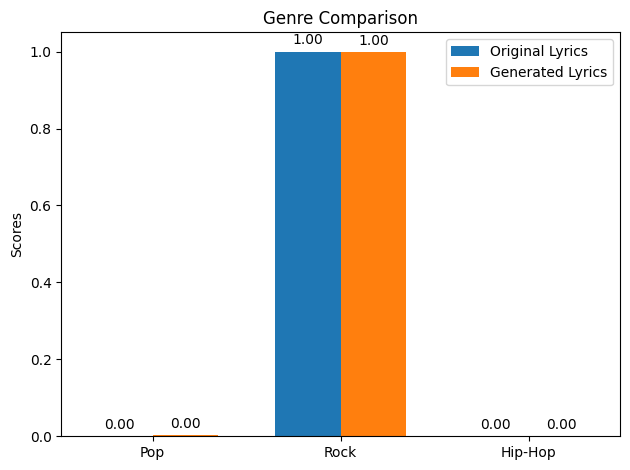

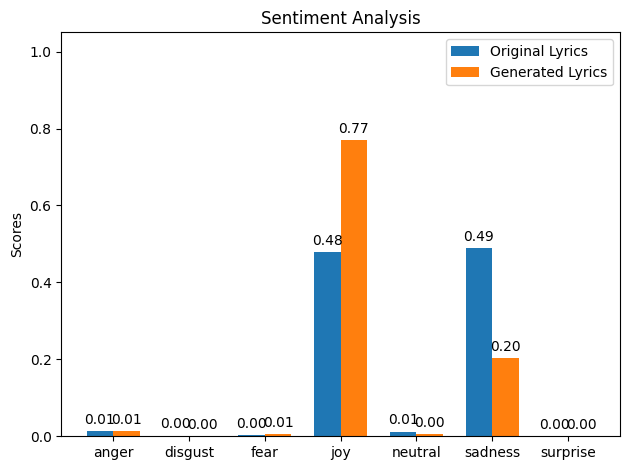

The generated lyrics for the song "Honesty" of Billy Joel:

Love look at me i am the one
I am thinking of a love i have known
I have been searching for the daughter
I am trying to get to tell you
I say you have been taken a thousand years
And i know i would like to make it with
I am a woman in love
And i do not know what i have found
I am not the woman that you can not see
I will be your friend figure
And i am thinking bout a little prayer
I will find my love again
And i know that i will be there
I will be the one
I will be your friend figure
I will be the one
I will be your friend figure
And i can feel your eyes through my heart
And i will find my life away
Cause i am not there i can go
I will give you all my life every day
And i will be the one
I will be the one
I will be the one
I will be the one
I will be the one
I will be the one
I will be the one
I will be the one
I will be the one
I will be the one
I will be the light
When i feel the magic floating in love
And i can not believe 

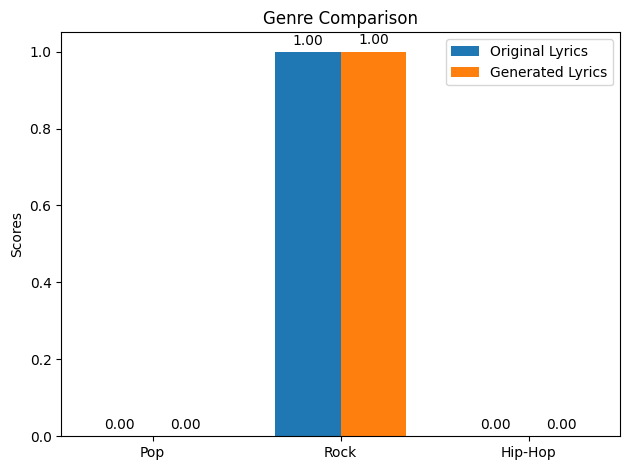

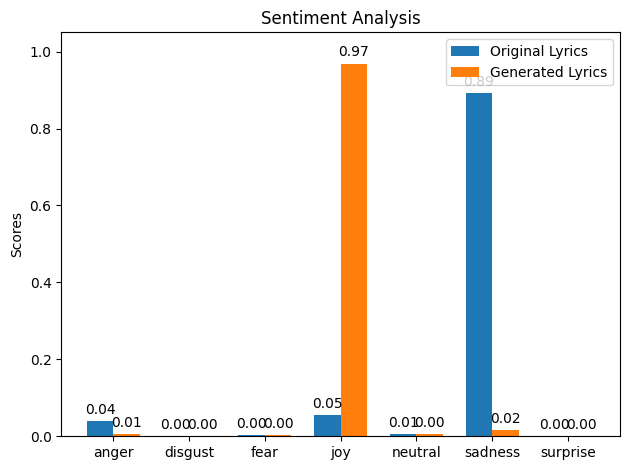

The generated lyrics for the song "Lovefool" of Cardigans:

Love is a place for earth
And i am going for a man
I am gonna have a fool
I am a man i am going to
I am a woman and i am playing a game
I am gonna write you right in my mind
I need a girl that i can not get a day
I am holding you with a bottle of a letter
I am a genie in a bottle baby
Gotta rub me the right way beside you
I can see you and i can not get it
I can show you i can show you i can show you some of the people
I can show you my love is done
I know i need to feel you in the truth
I can show you i can show you some of the love
I am gonna find you a little way
I feel the earth in shades
I will see you in my arms and fly me a sign
I can not believe that i am not gonna be with you
I can not believe that i am a prostitute
And i know that i could not be a fool
I do not want to be your downtime
I do not want to be your lover lover
I do not want to be your lover lover
I do not want to be your downtime oh
I am glad you won
You 

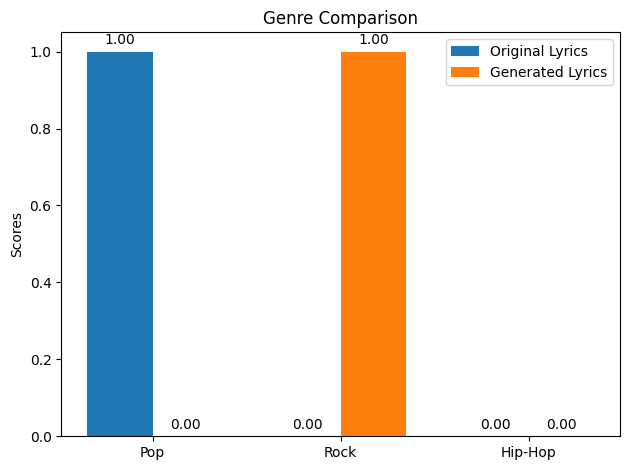

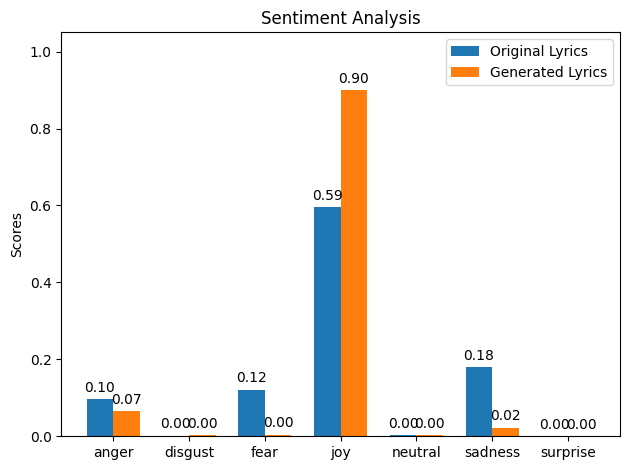

The generated lyrics for the song "Barbie Girl" of Aqua:

Love look at me i feel the sign
I will be the one one
And i have been so many long
I have been waiting for a game
I am picking out the light in my heart
I am not gonna get a stranger
But i am so glad to know you
And when i am lost in your eyes
I just want to dance with you
I want to hear you say the way that i can
Do you love me i will be there
I will be the one
Who loves me what to love me
I do not know how to live without
And i do not care what i am headed for you
I will be your friend figure
And i know you are the one that i can
Are i am falling in the sun for my heart
I am in your eyes
I am in love i am in love
I am in love with you
And the light that shines
I feel the way you can say
I want to dance with you
I want to be your lover and i will give you all my dreams
I want to touch you
And i will be the one
I will be the one
I will be the one
Who will love you so
And i can not believe it is true
And i have been waiting for y

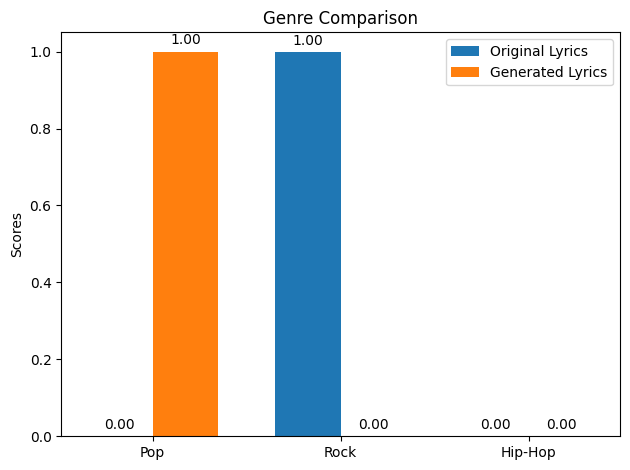

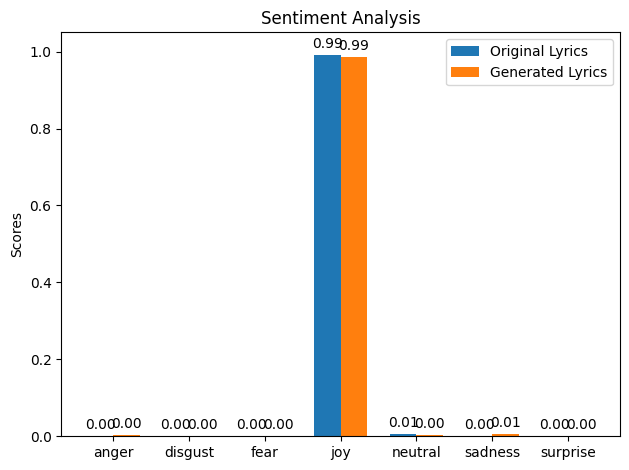

The generated lyrics for the song "All The Small Things" of Blink 182:

Love look at the two of us
Strangers in many ways
We have got a lifetime to share
And i would give you to the place
I will be the one
I will be the sunlight
And i will be with the longest
I will be the one to you
I will be the one
Who will bring you to stay
If you will be with me
And i will be with you
With you
With all the time
Let show the world of the world
Let the world take the light
Baby do not be afraid to be
If you say the world will not be
And i will be gone
I am a man in a dance
And i will be with you
You are all alone
And i will be with you
You are all alone
I will be the one
I will be the sunlight
I will be the one
Who will you be the one
I will be the one
I will be with you
And i will be with a small
When i am living
I am telling you what
You have a friend to me
--------------------------------------------
The original lyrics for the song "All The Small Things" of Blink 182:

All the small things
True 

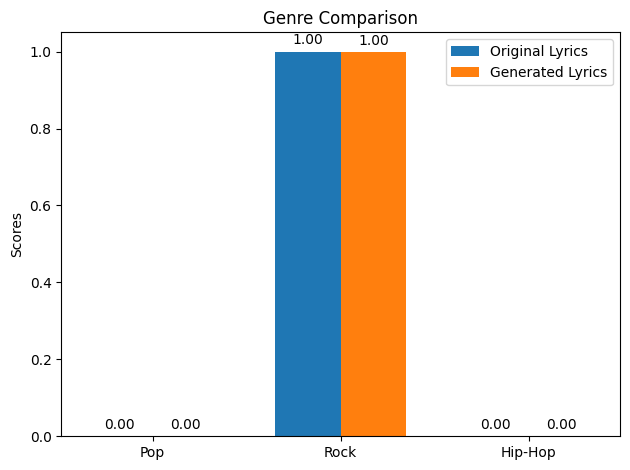

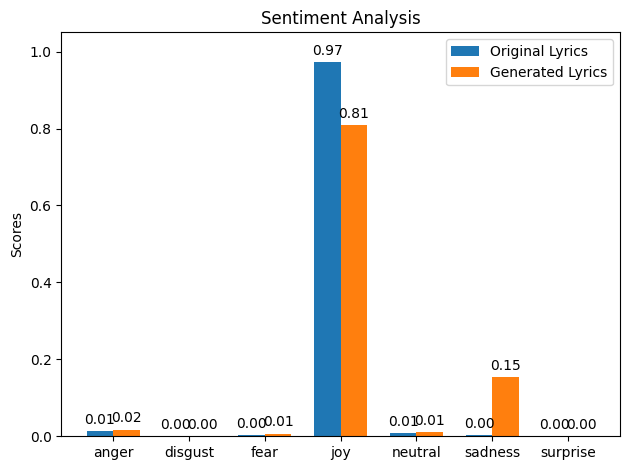

Test Scores: Cosine: 0.8808446049690246, Jaccard: 0.20014438899267134, BLEU: 3.09388277747673
#########################################################################################
The initial word is if

The generated lyrics for the song "Eternal Flame" of The Bangles:

If you see me walking down the street
And you are on the street and the rain
And the mountains the reply is
The moon is on the trees
And the mountains of the air
And the mountains capped mountains and
And that it is not the same
And the world is falling
And the music is gone
We are riding in the heat
The music of the world
And the eagle band
And the music of the world
And the snow capped mountains and
From the distance
The ocean is on
The sky is found
And it is the same of july
I will feel the show
For a man of the love
I can not get a long
And i am thinking of a hero
And i am thinking the flowers
I am gonna have a fool
And i am just a little man
And i am just a little man
I am gotta have a hero
I am gonna be a fool

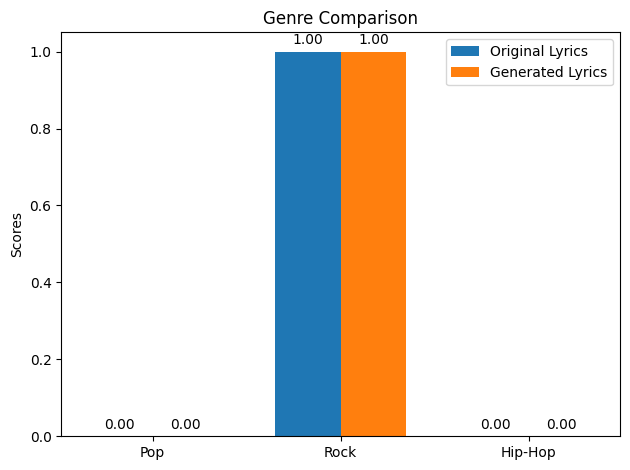

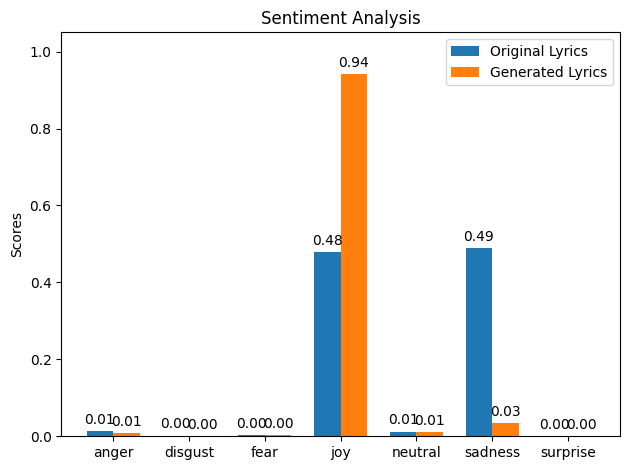

The generated lyrics for the song "Honesty" of Billy Joel:

If you want it here it is come and get it
Mm mm mm mm make your mind up fast
If you want it any time i can give it
But you would better hurry cause it may not last
Did you hear what you do
If you want it any way i can not get it
Cause you would not have to do it
Cause you would not hide my colour
And i will not have to play it off
And i am gonna be a fool
I am gonna fight you
I am gonna fly on down
I wanna get up my mind
Do not know what you do
I do not know how to do
I do not want to be your clown game
I do not wanna be your clown now
Cause i can not help myself
I do not wanna be your clown now
I just can not seem to get it right
I do not wanna be your clown
I will not be your father
I will help you now
I do not want to be your clown
Just lay to keep on me
I just want to be with you
I want you for you
I know that you will not be there
I will be your father
I will help you all i will not lie
I will survive
I will not be your a

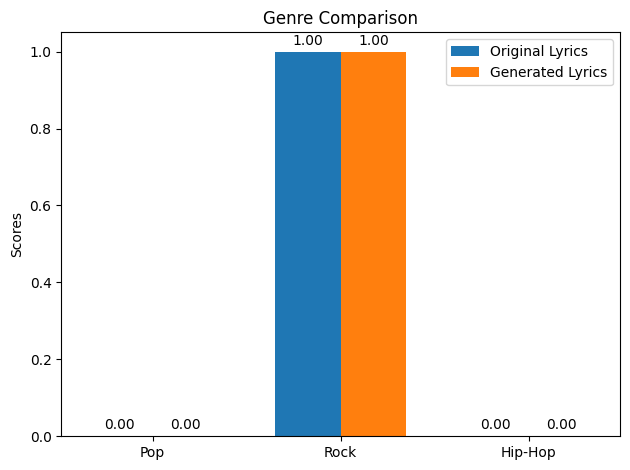

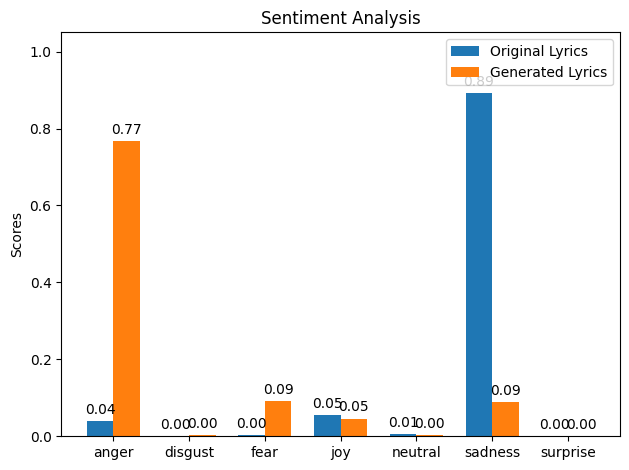

The generated lyrics for the song "Lovefool" of Cardigans:

If you are looking at me
That you are not gonna get out
You are gonna be a better
And i am gonna fly on down
And i am gonna fly on down
And fly away to my head
I am gonna fly on down and fly away
I am gonna fly on down
Then fly away
I am gonna fly on down for the
Last stop to this town
I am gonna fly on down for the
Last stop to this town
I am gonna fly on down
Then fly away
I am gonna fly away
--------------------------------------------
The original lyrics for the song "Lovefool" of Cardigans:

Dear i fear we're facing a problem
You love me no longer i know
And maybe there is nothing
That i can do to make you do
Mama tells me i shouldn't bother
That i ought to stick to another man
A man that surely deserves me
But i think you do!
So i cry i pray and i beg
Love me love me
Say that you love me
Fool me fool me
Go on and fool me
Love me love me
Pretend that you love me
Leave me leave me
Just say that you need me
Love me love me


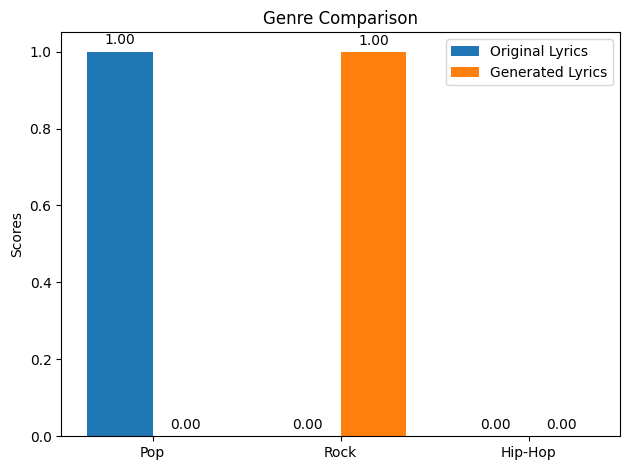

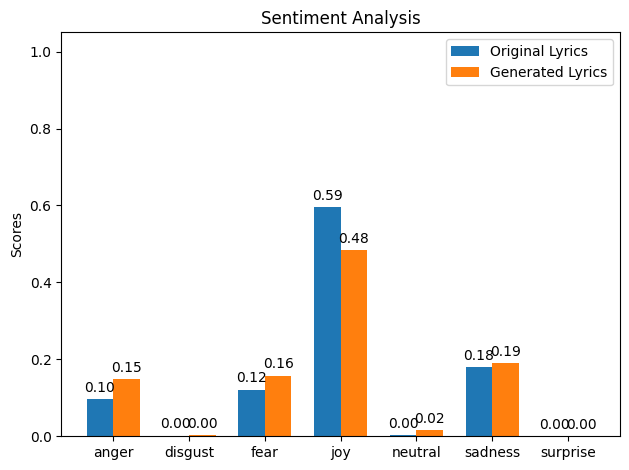

The generated lyrics for the song "Barbie Girl" of Aqua:

If you want it here
Make it easy to make it
But you can not get it
Cause you will not have to understand
Just do not think it
It is the way that you wanted
When you want it to you
You know that you will not do
It is just your woman it is just so good
--------------------------------------------
The original lyrics for the song "Barbie Girl" of Aqua:

Hiya barbie
Hi ken!
Do you want to go for a ride?
Sure ken
Jump in
I'm a barbie girl in a barbie world
Life in plastic it's fantastic
You can brush my hair undress me everywhere
Imagination life is your creation
Come on barbie let's go party!
I'm a barbie girl in a barbie world
Life in plastic it's fantastic
You can brush my hair undress me everywhere
Imagination life is your creation
I'm a blond bimbo girl in a fantasy world
Dress me up make it tight i'm your dolly
You're my doll rock'n'roll feel the glamor in pink
Kiss me here touch me there hanky panky
You can touch
You can play


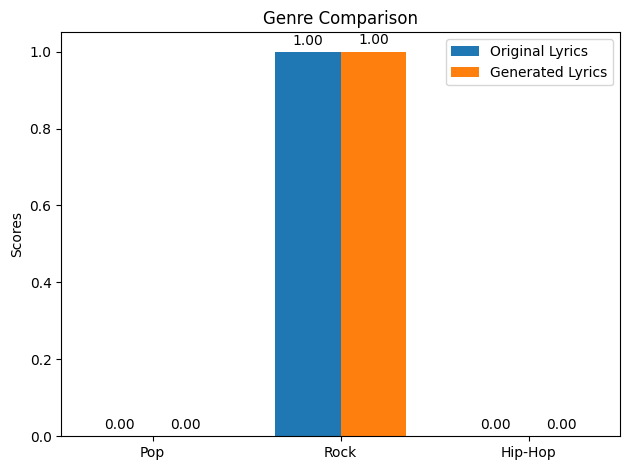

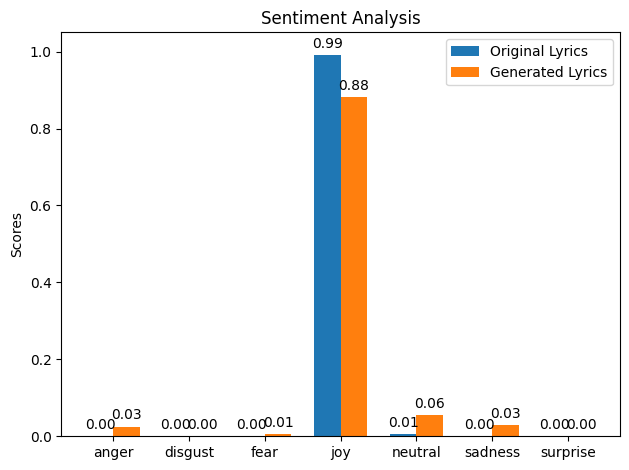

The generated lyrics for the song "All The Small Things" of Blink 182:

If you want me to tell you what you feel about me
I do not want to be your clown now
I do not want to be your clown back
Does not matter what you do
I do not want to be your clown
I want to be your love
I want to be your love
I want to be your love
I want to be your love
I want to be your love
I want to be your love
I want to be your love
I want to be your love
I want you to stay
I do not want to be your clown
Just do not matter what it is
But you do not want to be your attitude
If you want to show me that you care
I do not want to be your clown
Just do not be afraid to be with you
Do not want to be all by myself anymore
I do not want to be your clown
Just let me show you
Just because you will never be wrong
Do not be afraid to be with you
Do not you know
--------------------------------------------
The original lyrics for the song "All The Small Things" of Blink 182:

All the small things
True care truth brings
I'

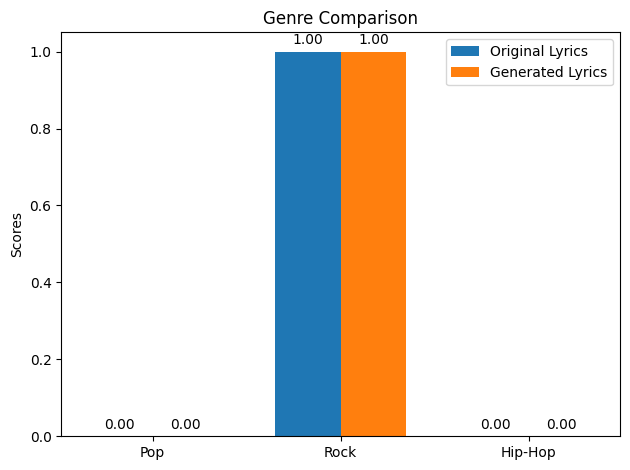

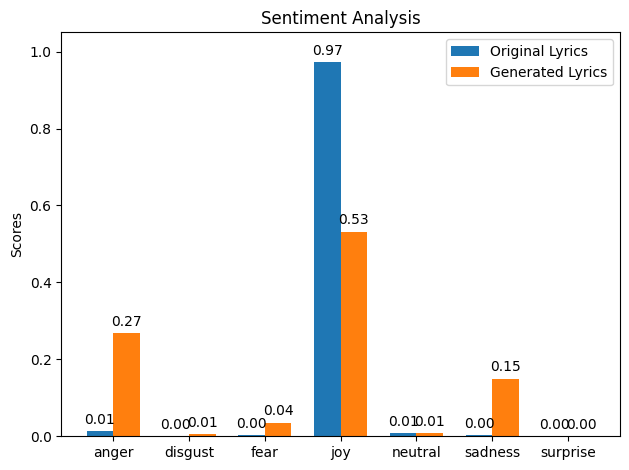

Test Scores: Cosine: 0.8564979314804078, Jaccard: 0.16079345846469134, BLEU: 1.9196424885765073
#########################################################################################
The initial word is what

The generated lyrics for the song "Eternal Flame" of The Bangles:

What i am going down
I am gonna find out of the love i have done
I will be your father figure and i am not sure
I am gonna be with you
Wanna be the one and the guy you know
I will not be your side again
I will not be your father figure
I will be your father figure with you
I can not believe it is a river
And i will not have to work that i can not get this
Cause i have got a feeling to live
And it is not easy to be
And i am not to let you know
What can i do not know what i do
I will not be your lover
I do not know how much i do
I know that you are never gonna be
I am gonna do not want to be
I am gonna have to let it go
And i do not wanna be your clown
Cause i am doin a place on
I have got a song to have a fight t

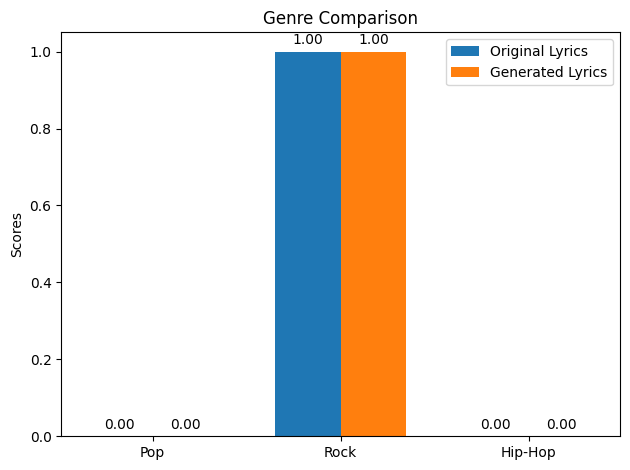

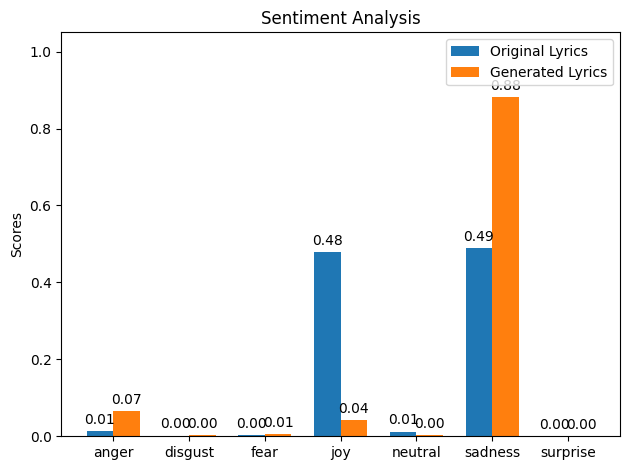

The generated lyrics for the song "Honesty" of Billy Joel:

What child is this who laid the rest
The moon is sleeping and the sun is on
Oh wo ho the king is not
The moon is on the wind
And the moon is on and the sun is on
Oh what a little boy for a life
In the church of the night
In the church of the people of the world
Of the moon of blue blue eyed
He is in the earth of the night
He is in the eye of the night
He is just a hired that
He is gonna get caught
He is just the same of the people
He is just a little woman
He is gonna get out of the night
He is fighting and biting and riding on his horse
He is going and the sun is right
He is gonna be strong and he is a little bit
With a voice he is a lot of one
And he is going for speed
He is going for speed
He is going for speed
He is going for speed
He is going for speed
He is going for speed
He is going for speed
He is going for speed
He is going for speed
It is not the same
He is going for speed
He is going for speed
He is going for speed

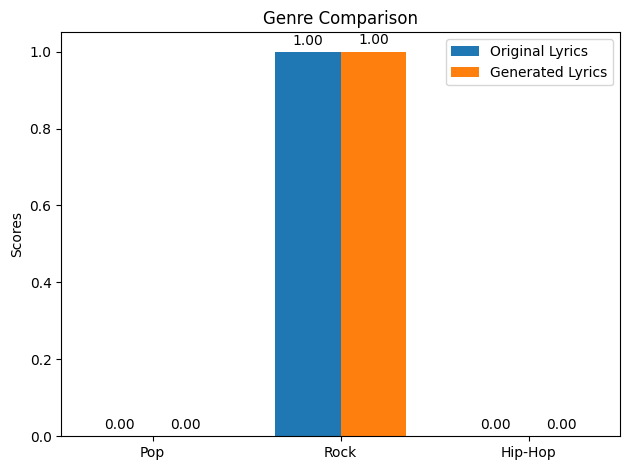

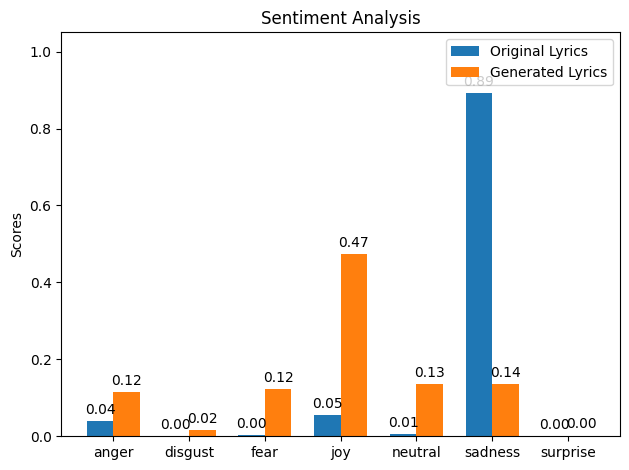

The generated lyrics for the song "Lovefool" of Cardigans:

What i am going down
I am gonna find you some time
I want to be your love
I want to be your love
I want to be your love
I want to be your love
I want to be your love
I want to be your love
I want to be your love
I want to be your love
I want to be your love
I want to be your love
I want to be your love
I want to be your love
I want to be your love
I want to be your love
I want you will not be
And i will not hold you
I do not want to be your lover
I want to be true
I do not want to be your
I want to have faith
Now i am gonna love you
I do not want to be your clown
Chorus
I want to be down
I am not you
I am not you
I am not i am
Cause i am
I am gonna do that i am
I am gonna do that
I am not so bad
I am in love
I feel for you
I am in love
I feel the magic
I am in love
I have got to be
And i am not so tough
I am telling you why
I am
Sometimes i have ever insecure
--------------------------------------------
The original lyrics for

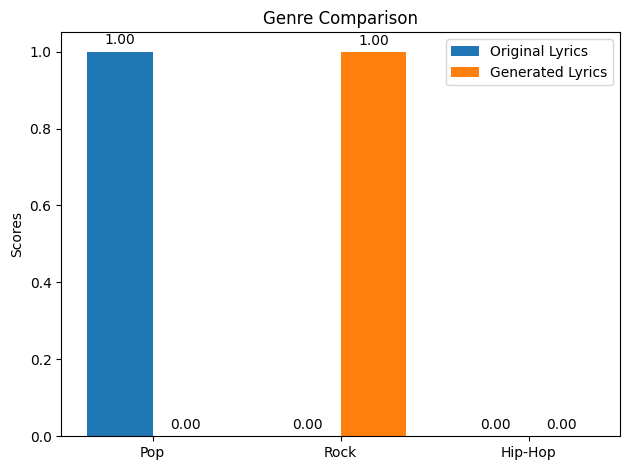

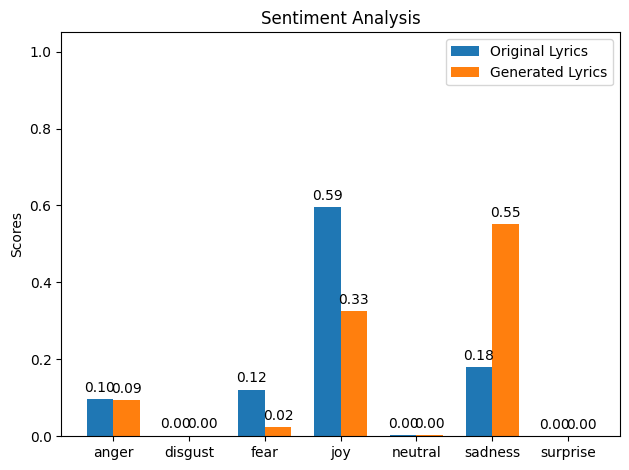

The generated lyrics for the song "Barbie Girl" of Aqua:

What child is this who the king of the world
He is in her love that you have been so far
And he is so hard to remember
So much to be a place to be
The one of the world of the world of the world
And the only thing of all the time
And i have seen a thousand money for the man i have known
Oh my god i would love you so
I miss you i miss you
And i know that we could be so far
Every day i know that i was found
That i have been searching for the world
I was born to make you happy
I would give you the best
I was not the one i would have to know
I was not to be the same
I was not the one to live
I have got to be the one
I have been searching for the way i could
To have you would be
A dream that i can
Are the one
I was afraid to be with you
The world is all i have to say
Oh my heart was on me out
And i know i have to go away
I am the one who loves me
Who you are out of the spell
When i say what i am saying
I am a little man i am in love
W

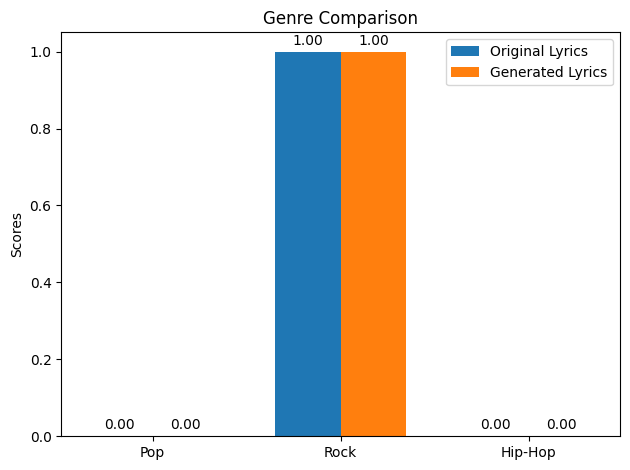

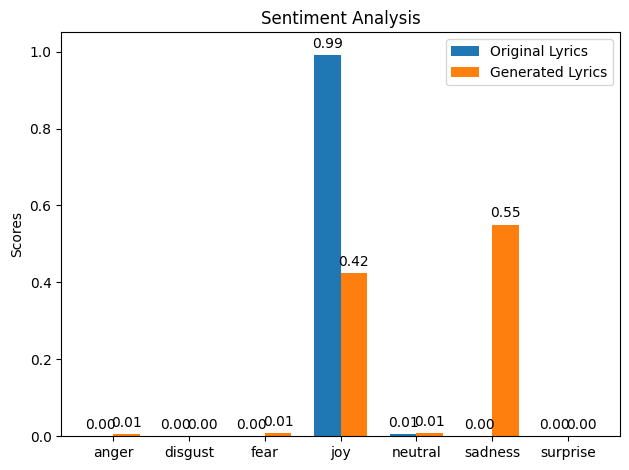

The generated lyrics for the song "All The Small Things" of Blink 182:

What child is a place on the street
And you are looking at the same
In the moment we are in time
We are gonna get a time
To play that you will not know
We will be waiting there a star
And then we would be a movie
On the ground
And the moon is so heavy
And it is the end
We will be the one
And i will be here
And i will not be here again
We will be the fool
I am not gonna be so
And you will be here
You will be the one
I will be the one
I will be the light
I will be the light
I will be the light
I will be the light
I will be there for the time
I will be the sunlight
With a voice in a man
I will be a man
I will ride with the sun
And the world is gone
I will be there
I will be the one
I will be the light
I will be the light
I will be with you
--------------------------------------------
The original lyrics for the song "All The Small Things" of Blink 182:

All the small things
True care truth brings
I'll take one lift
Yo

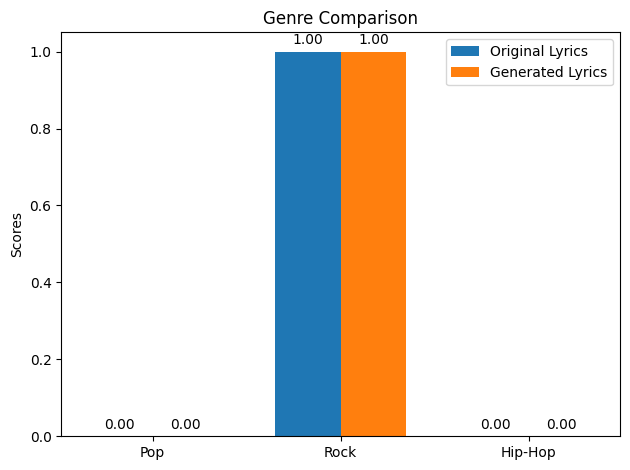

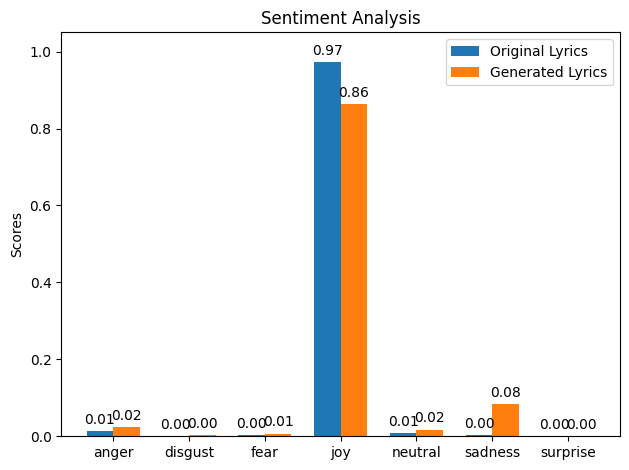

Test Scores: Cosine: 0.8568356275558472, Jaccard: 0.15281028097046676, BLEU: 2.4755794842129526
#########################################################################################


In [35]:
args['midi_features_type'] = 'instruments'
args['frames_per_word'] = 1
music_features_dim = get_dim_by_type(args['midi_features_type'])

configuration_name = f"midi_features_type_{args['midi_features_type']}_frames_per_word_{args['frames_per_word']}_lr_{args['lr']}_dropout_{args['dropout']}_num_layers_{args['num_layers']}_weight_of_lines_{args['weight_of_lines']}"
model_name = f"model_epoch_{args['epoch']}_{configuration_name}.pth"
# print(f"Loading with the configuration:{model_name}")

test_dataset = LyricsMelodyDataset(test_lyrics_df, midi_files_path, args['frames_per_word'], midi_features_type=args['midi_features_type'], avg_duration_of_word=avg_duration_of_word)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# load the best model from the disk from here f'models/best_model_lr_{lr}_dropout_{dropout}_weight_of_lines{weight_of_lines}.pth'
model = LyricsGenerator(embedding_dim, music_features_dim * args['frames_per_word'], hidden_dim, output_dim, num_layers=args['num_layers'], dropout=args['dropout'])
model.load_state_dict(torch.load(model_name))
model.to(device)

result_per_word = {}
for word in initial_words:
  result_per_word[word] = test(model, test_dataloader, word)

results[configuration_name] = result_per_word

# Test - Approach 3 (Combine Features - Melody and Instruments)

The initial word is love

The generated lyrics for the song "Eternal Flame" of The Bangles:

Love you are the sunshine
That i never knew that it is not a good way
It is a steady on the hand
It is a nice day
It is a nice time
With a day of a man
And there a strong man
I am gonna get a new
And i am gonna find you a
And i am gonna find a dream tonight
I will be the one of the queen
I will be the one to the end
And i am gonna fly it up
And there is a new one
I have been a fool cause i am in love
And it is not a fool i have done
I have been a fool for you
I have been a fool that i am so strong
I have been a fool for a love
And i have been a fool for a love
And i have been been a fool i have to be a one girl
I will be the one for you
I will be your father
I will be your preacher
I will be your preacher in my life
I will be the one
I will be the one
I will be the one
I will be the one
I will be the one one love will be a woman
I am a man of my world
I can be your sweet sweet smile
I need your

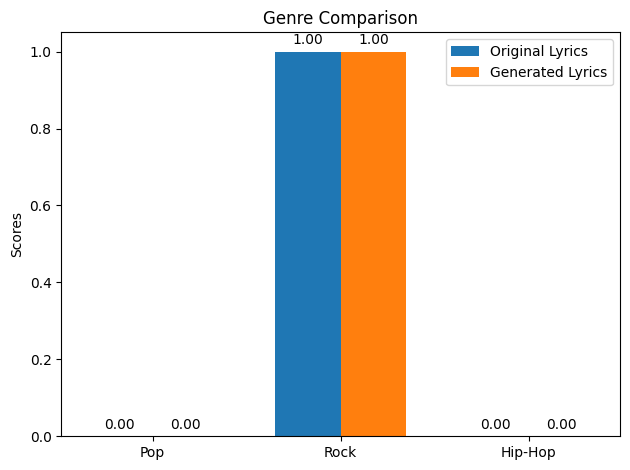

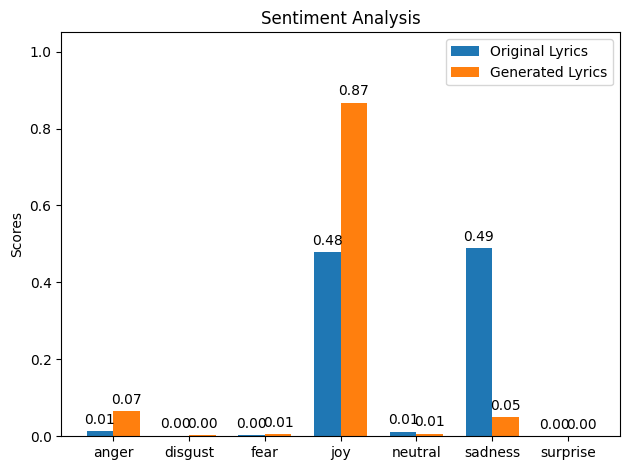

The generated lyrics for the song "Honesty" of Billy Joel:

Love look at the world
I think you have to be a guy
I have been a fool of a child
I was a little who i have known
And i have been been a fool for me
I have been a fool for lesser and i have been strong of my heart
I have known to make you to know
And i will be waiting for you
I am in a fool for you
I am a little one two you
I am gonna get it to my heart
I have made a lot that i am in love with me
I know i have seen a lot for a star
I am a little who i am gonna break my mind
I have known to make you to be a star
I will be a one to keep my own
I will be the one
I will be your preacher
I will be your preacher
I will be your father
I will be your preacher
I will be your preacher
I am a little one
I am gonna make a world of the fight
I will be the one
I will be the one
I will be the one i will be a fool
I will be the one i will be a one
I will be a fool
I will be the one i have to be
To the one for you
-----------------------------

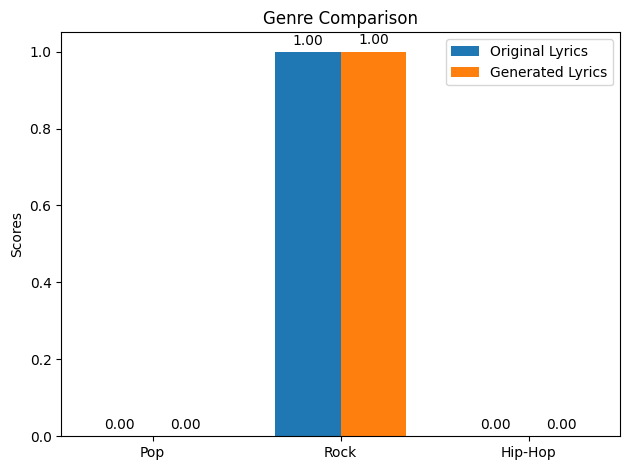

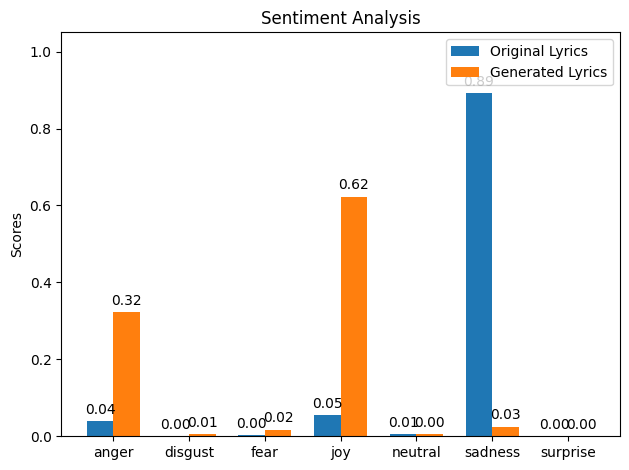

The generated lyrics for the song "Lovefool" of Cardigans:

Love you are the best of you
I can not believe you love me
I can love you better than
I can not believe you love you
I do not want to be down
I just want to be with you
Just that i have got to
I have got a fool for you
I do not want to fade away
I do not want to fade
I am a fool in a girl
You gotta be your clown
I am gonna be strong
I am gonna break a little
I do not want to fade away
I just wanna be with you
Just just a way to me
I do not want to fade away
To you be just a way
I do not want to fade away
Give me one way
I do not want to fade away
Give me one baby
I do not want to be your place
I can not let it go
I will be your father
I want to be your love
I want to be your love
I want to be your love
I want to hear you say
I want to be your arms
I want to be your love
I want to be your arms
So i can be crazy but i am not crazy
I just wanna be with you
I do not wanna be your clown
--------------------------------------------


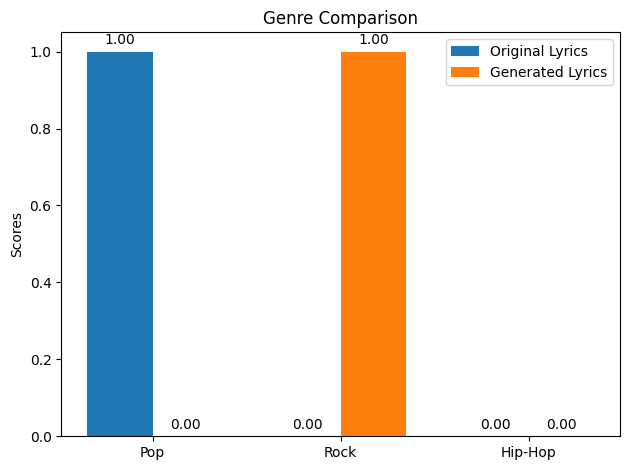

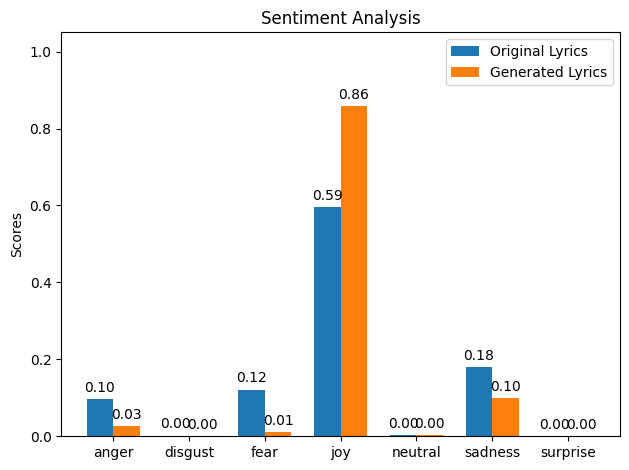

The generated lyrics for the song "Barbie Girl" of Aqua:

Love look at the world of my hand
I will be a fool to your heart
I will be the sunlight
I will be the one
I will be lying
I will be the light
I will be the one
I will be the light
Where i say you have to be alone
To make you and i know
But i will give my pride
I would be a fool
I will be the light
Where i can not be there
I will be the one
I will be the light
Where i will be sure
I will be there
I will be the one
I will be your father
I will be your father
I will be your father
I will be your father
I will be your father
I will be your father
I will be your preacher
I will be your preacher teacher
I will be your father figure
I will be your father
I will be the light
Where i will be your side
I will be your father
I will be your father figure
I will be the light
Where i need you more
And i will be the one
I will be your father
I will be your father figure
I will be the one
I will be the light
Where i need you
-------------------

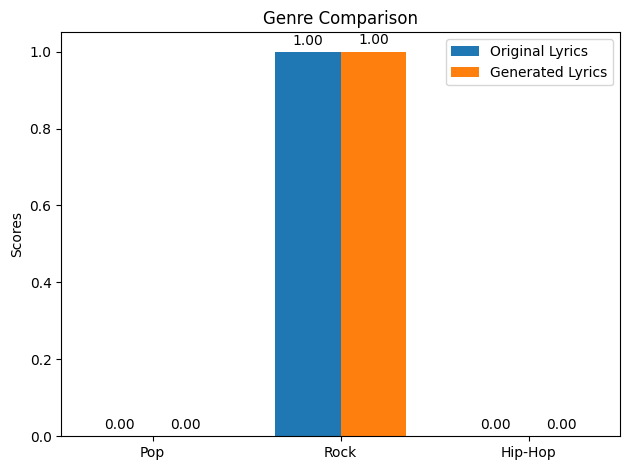

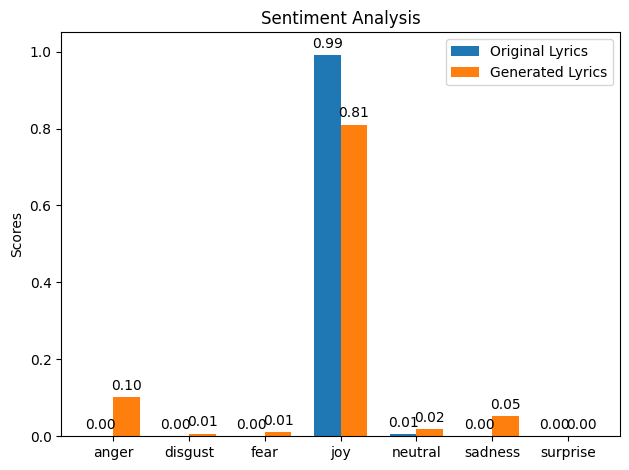

The generated lyrics for the song "All The Small Things" of Blink 182:

Love is the best that i was young
I am holding my way to the top
I think that i was leaving
I am waiting my way
I am holding in the world
I am holding my mind
I want to be with you
I want to be with you
I am a one in a white
I have a happy in a world
And i am holding
I am holding in a long
And i am a man in a preacher
And i am holding in the morning
I am gonna make a big
And i am gonna fly a
And i am shaking in the world
I get a law and i am in the
I get the law and i am gonna
But i am on the top
And i am looking of a white
I am gonna make you and i am
I am gonna break a city to the end
I am gonna fly this city and i am gonna fly
And i am gonna break this city
I am gonna break this city
I am gonna make this world tonight
I am gonna make you tonight
--------------------------------------------
The original lyrics for the song "All The Small Things" of Blink 182:

All the small things
True care truth brings
I'll take

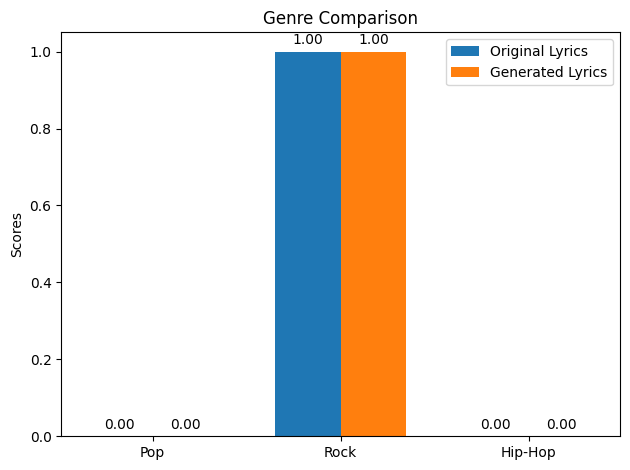

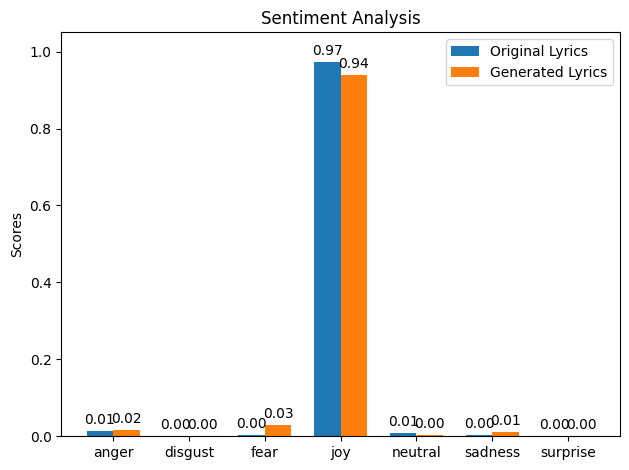

Test Scores: Cosine: 0.899254560470581, Jaccard: 0.15856065027477045, BLEU: 2.6516306155451015
#########################################################################################
The initial word is if

The generated lyrics for the song "Eternal Flame" of The Bangles:

If you see me walking down the way
And i am no of the state i have seen to go
I have got a lot of the world i have got to be
I am the one who i want to get it
I want to be with you
I am a man to stay you in my mind
I can be a fool to keep you through
I have got to have a new life
I have got to be around
For you do not know what i am not
I want to know that i have got to show you
I do not want to say you need you
I want to be with you
And i will be a fool
I will be your love
I will be your love
I will be your love to know
To love you
I will be your love
I will be your father figure
I will be your father figure
I will be your father figure
I will be your father figure
I will be your father figure
I will be your fathe

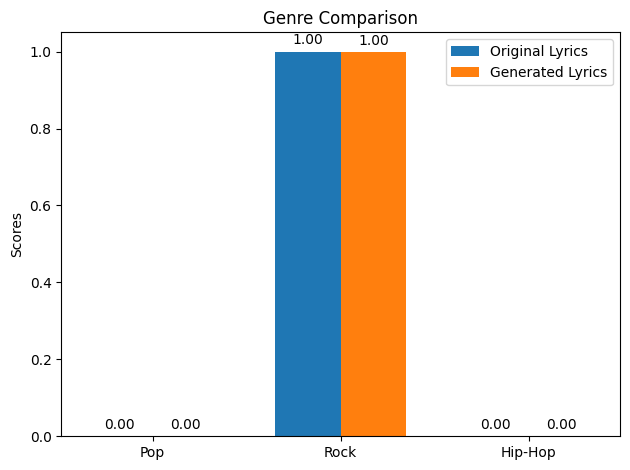

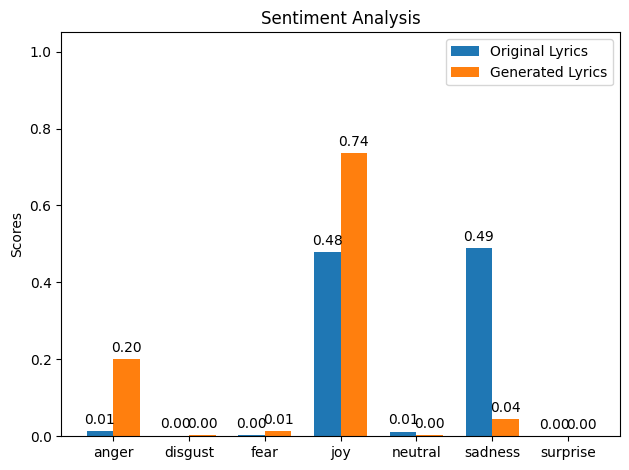

The generated lyrics for the song "Honesty" of Billy Joel:

If you want to be a chance to you
You do not want to be a fool
You would not say it is a game
That you are going to get a dream
I am gonna get it to you
You would be coming to be a fool to keep you
You are gonna make a chance to make you know
I will be your father
I am gonna get it to be with you
I am gonna be with you
I am gonna be with you
I am gonna be strong
I am gonna be strong
I am gonna be strong
I am gonna be strong
And i am gonna be strong
I am gonna make you and i am gonna break
And i am not gonna give you right
I will be your arms
If you say that i would not resist
I will be the one you would be
I will be your arms
I need to be your arms
I would be your love you can not let me go
I will love you better than that
I am gonna love you
Over the reason i want to know
I am gonna make it all i do
I am gonna make it right
I am gonna love you all i am with you
I do not want to fade away
I do not want to fade away
-----------

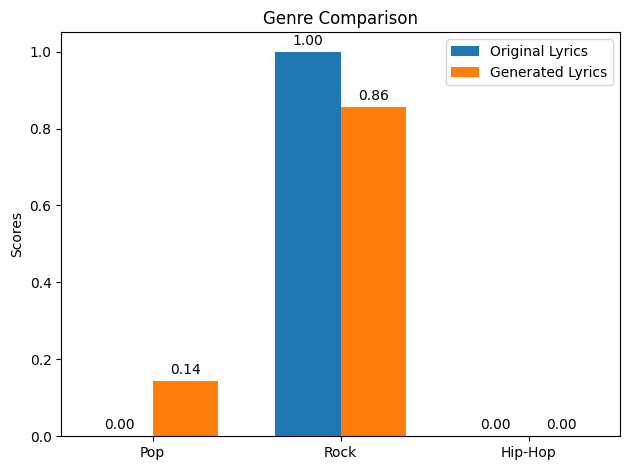

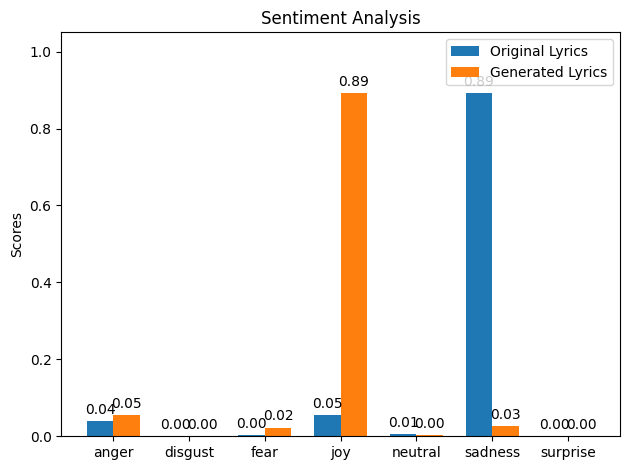

The generated lyrics for the song "Lovefool" of Cardigans:

If you are so fine
And it is not too much
Do not you know what i do
I am a man to your desire
I want to be with you
I am gonna be strong
I am a fool for you
I do not want to be with you
I will be your father
I am gonna be strong
I am gonna be with you
I do not want to be your side
I do not want to fade with you
Just to be with you
I am a fool
I am gonna take you
I need a woman of my heart
I do not want to fade away
I just want to be with you
I need you
I am a fool you would be strong
I am a fool that i am feeling
I do not want to fade
I am a fool that i am feeling
I am a fool that i am feeling
I am the man who i do
I am gonna take you
I am gonna love you
I am gonna love you
I am gonna love you
I am gonna love you
I am gonna love you
I am gonna love you
I am so glad
I am gonna love you
I am gonna love you
I am so glad
I am gonna make it
I am a woman
--------------------------------------------
The original lyrics for the song "

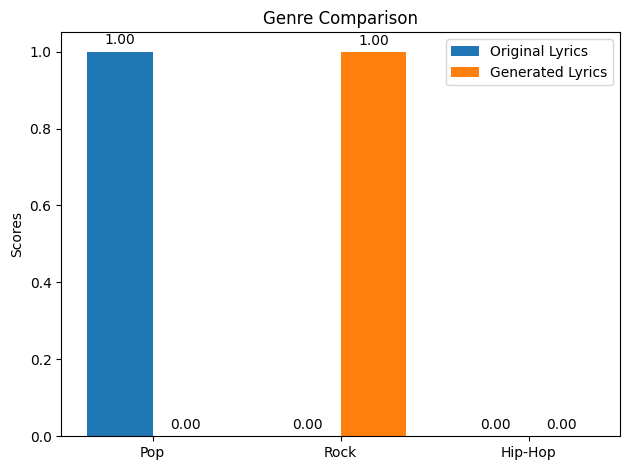

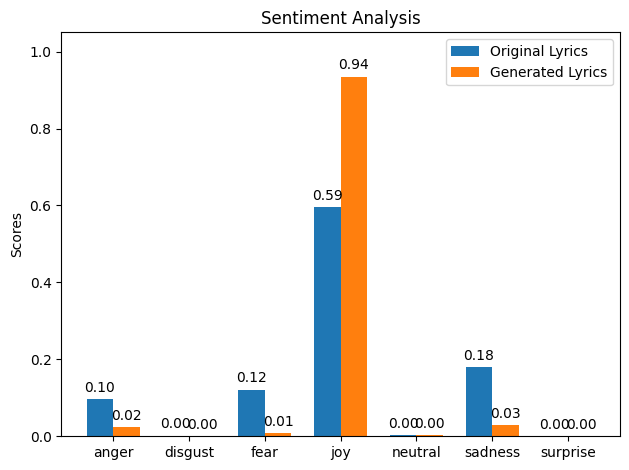

The generated lyrics for the song "Barbie Girl" of Aqua:

If you want to leave it down
It is a way that you can not see
You would not say it is the guy
It is a promise that i can not see
I am gonna be the one of your love
I have got a woman to you
I am gonna be with you
I am a man in your love
You are gonna take me down
I am gonna be with a fool
I am gonna take it to you
I am gonna be with you
I will be your baby
I want to be your love
I want to be your arms
With your heart in your heart
You are my fantasy
I will be your preacher
I will be your preacher
I will be your preacher
I will be your father figure
I will be your father figure
I will be your father figure
I will be there my world
I will be your preacher
I will be your father
I will be your father
I will be your father figure
I will be the one
I will be the light
I will be the one
I will be the one
I will be the light
I will be the light
I will be the light
I will be the light
I will be the light
I will be the light
I will be the

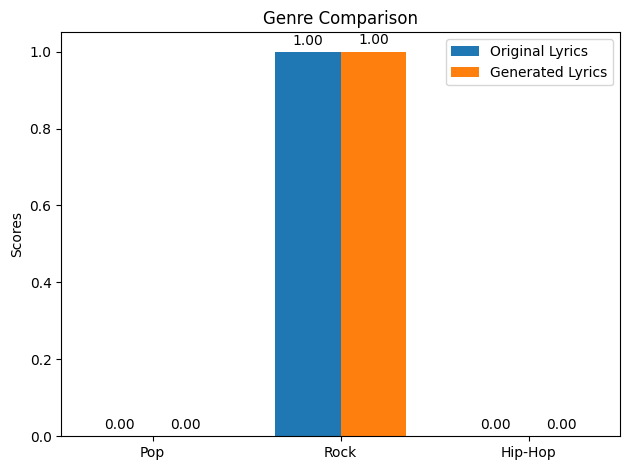

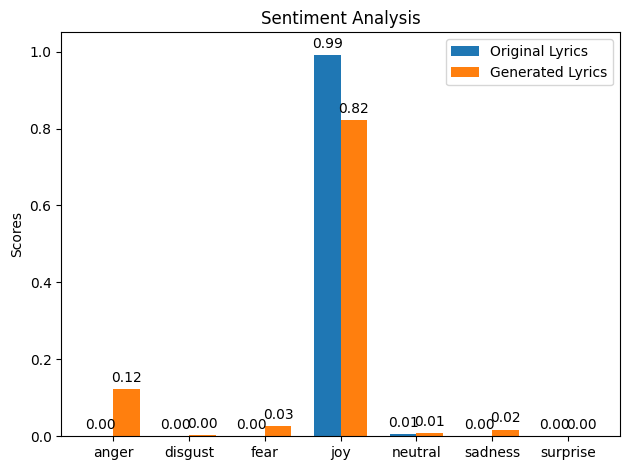

The generated lyrics for the song "All The Small Things" of Blink 182:

If i have known a long of mind
I am gonna get a new
I am gonna fly a dance
And i am gonna fly it up
And i am gonna be a fool
And i am holding my way
And i am gonna and a world to you
And i have been a fool to stay
And i am gonna to make a time
And i will be dancing
I will be the one for the end
I will be a place for the time
I will be the one of the night
I will be a place in the world
I will be the one of the night
I will be a place for the world in the night
I will be the one of the evening
I have been a fool in the evening
I have got a lot of a white
And i am in the state of the fight
I am in the world i have been a spiritual of a preacher
I have been searching for this way
I have been searching for this
I have been waiting for this way for the time
I have got a lonely race
--------------------------------------------
The original lyrics for the song "All The Small Things" of Blink 182:

All the small things
Tru

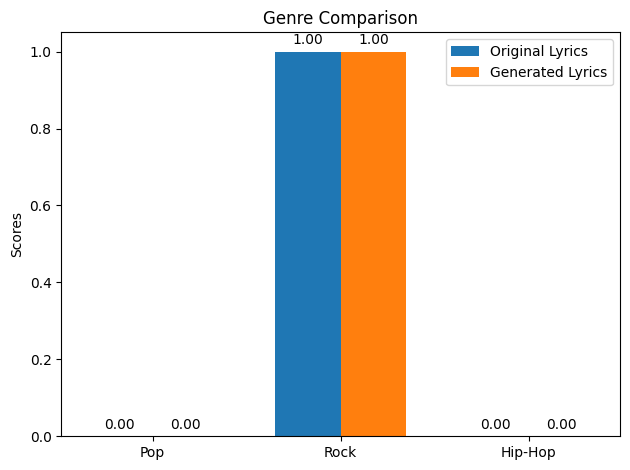

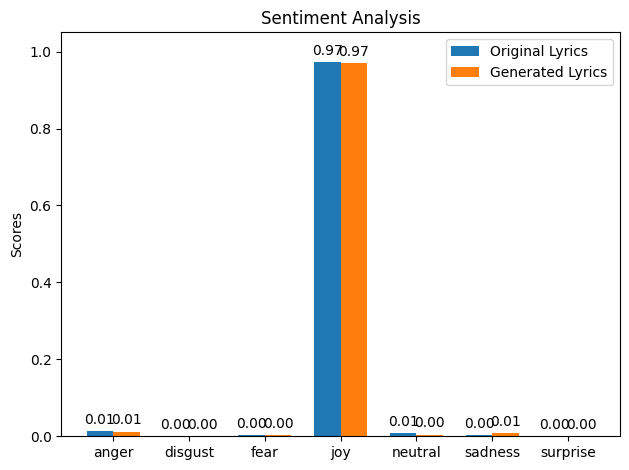

Test Scores: Cosine: 0.9057040691375733, Jaccard: 0.19130701862183114, BLEU: 2.998502790547973
#########################################################################################
The initial word is what

The generated lyrics for the song "Eternal Flame" of The Bangles:

What is the way that i have been
It is not so much
And it is not so much it is like it is
It is just a way of passing
It is a girl it is a little place
It is a good time
It is a nice day
But it is not the old people of a place
I have got a lot of the evening
I have been looking for a long of a lonely
A angel and i die
She is a little man i am gonna sing
And the world is on her
I am gonna find a little of the night
I am a man of a white suit
I am gonna be a place for a world
I am gonna be a city for a new
I have been looking for a long time
I have got a lot of a child
I have got a lot of a place for a place
I have been searching for a long time
I have been a fool for lesser of the world i have been looking for her

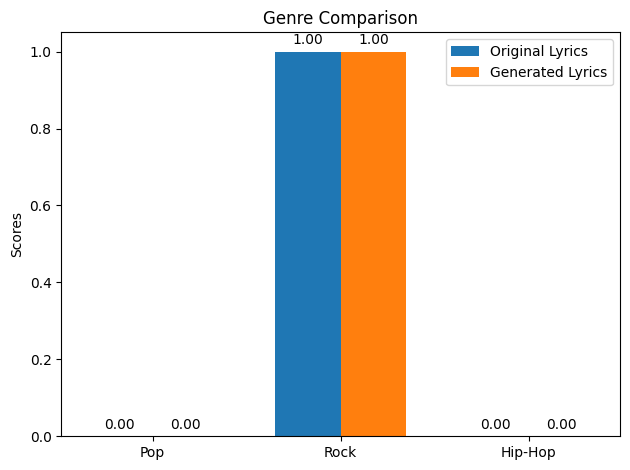

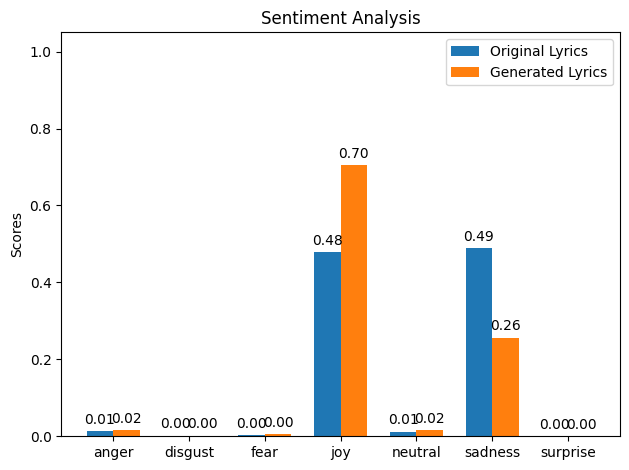

The generated lyrics for the song "Honesty" of Billy Joel:

What child is a little life
And what it was not a friend
Who was a place of the man
He is a little life for the man
He was fighting the light of a winter
He is a dream of a hand
He is not a fool of a bottle
But he is not a lovely time
With the country of the poison life
In the country the past
He is going to be a dream of a hand
He is a man of a hand
He knows that he was not found
To be the one of the country
He is a place of the country
He read the swingers he is in her eye
He says that he is not
He is the son of a preacher
He was a sister of the fight
He was the kind of the queen
He knows that he was
But he is all a drag
He is the one that he was
He is a preacher boy
He is the one of the fight
He read a dream that the life
He is the queen and the law same
He is a little man for a preacher man
In the country of the country
He is a place that the big world
He will not tell the world of the fight
He will bring him the place to 

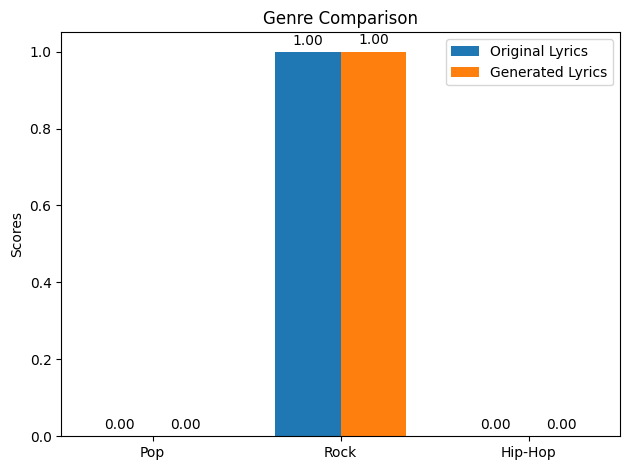

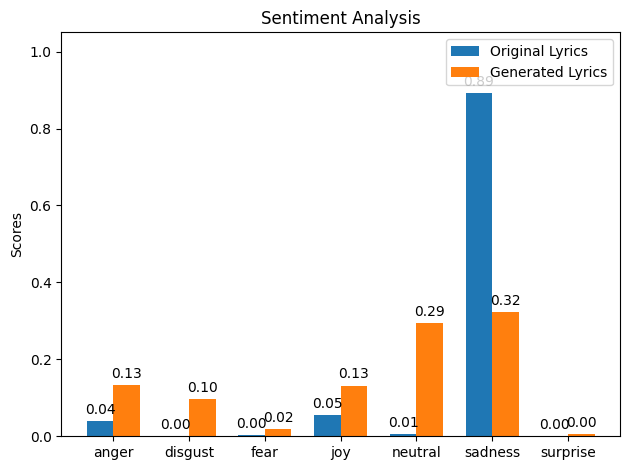

The generated lyrics for the song "Lovefool" of Cardigans:

What you are so fine
And i am gonna find you to find
I am gonna find you a new way
I would be your love
I am gonna make it all again
I do not want to fade your mind
I do not want to be your nasty
I do not want to fade away
I do not want to be down
I do not want to be your baby
I do not want to fade away
I just want to get with you
I am gonna get it
I am gonna make you
I am gonna be strong
I am gonna make you
I am gonna know
I am a fool you can be
You are gonna be strong
I want you baby
I am gonna be strong
I am gonna be strong
I am gonna be strong
I am gonna take me
I am letting you go
I am letting you with you
I do not know you are
You are alone i am
I am gonna love you
I am letting you
I am the one who wants
I am gonna take you
I am letting you
I am letting you
I am letting you
I am letting you
I am letting you
I am letting you
I am letting you
I am letting you
--------------------------------------------
The original lyrics

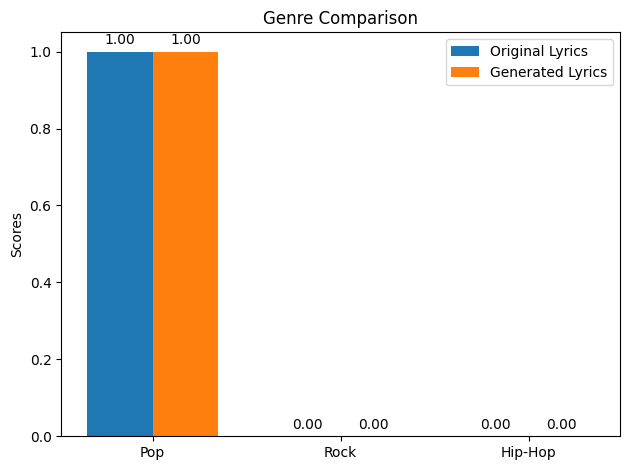

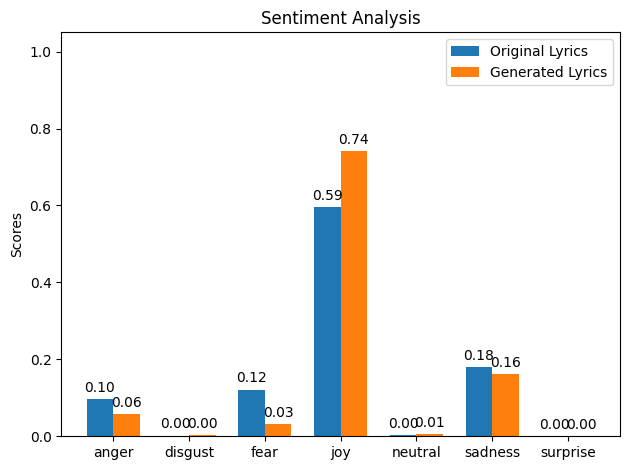

The generated lyrics for the song "Barbie Girl" of Aqua:

What child is a little day
Two night and the night
The night is lying through
The moon is sleeping
And i was lost her long
And he is been a dream
But he is not been a cruel
But the rural of the sea
He is a little boy
In the meadow of the poison
He is a big boy
In a new old
He is a loaded of a hand
But a dream and a world
He is a big of a big
He is the big of a
It was a place
But i am on the city
He is the one
He is a baby of a hand
He is a little big
But i am on the world
He is a little big
In the country of the country
He is the distance
He is a baby
He is the baby of a hand
He is the dream
He is the best of the fight
He knows he is a man
He says that he is
She is a man of a preacher
He is a big man
He is a man of a preacher
He is a preacher man
She is a sister of a preacher
He is a preacher man
She is a man of a preacher
He is a loaded in a world
He is a preacher of a preacher
--------------------------------------------
The o

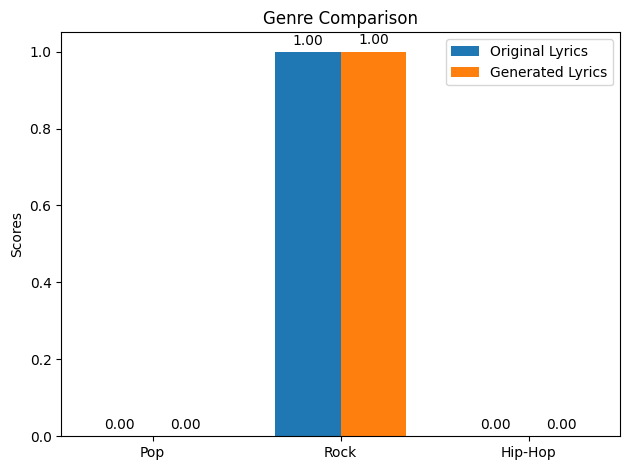

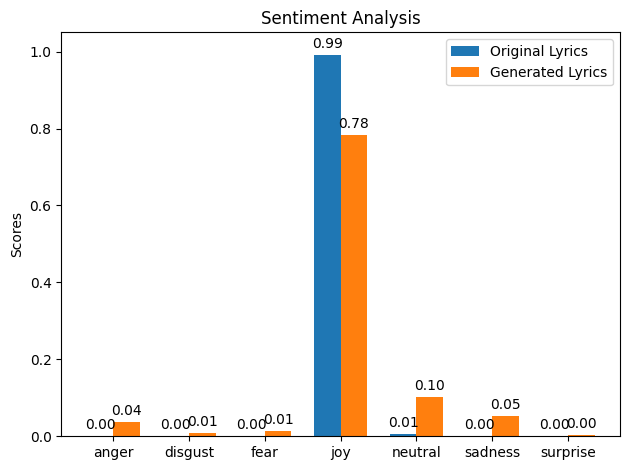

The generated lyrics for the song "All The Small Things" of Blink 182:

What to be a fool
I am a song and i am in the dark
And i am gonna be a place
And i am blessed a kid
And i am a man in a white
And i am a man
And i am in the world
I have got a lot of the world
I am holding my eyes
And i am in the awful
I am holding my bed
And i am blessed in a white
I am a man of a preacher
I have got a lot of the world
I have been a fool
And i am blessed in the dark
And i am the waiting
And i am blessed in the top
And i am a man
I am in the awful
I am blessed in a glance
I have got some a man for a man
I am shaking in the world
I am gonna paint this city and i am gonna fly
And i am the one of the city
I am the one of the city
I am gonna take a city to the end
I am gonna get a dance
--------------------------------------------
The original lyrics for the song "All The Small Things" of Blink 182:

All the small things
True care truth brings
I'll take one lift
Your ride best trip
Always i know
You'll

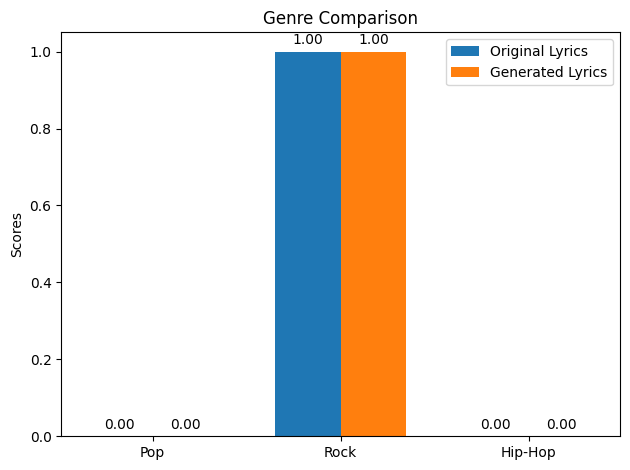

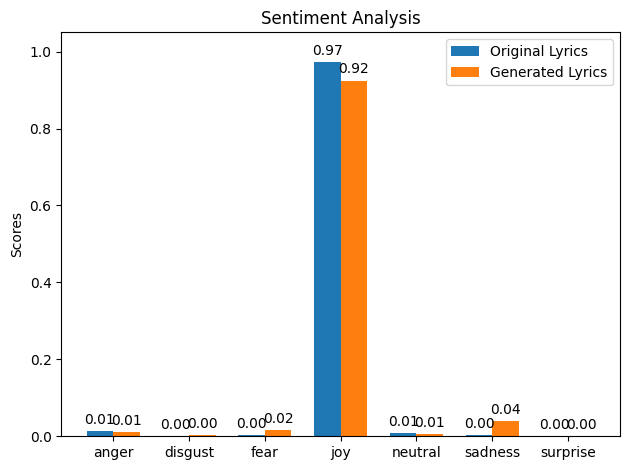

Test Scores: Cosine: 0.8460628747940063, Jaccard: 0.11986152447308666, BLEU: 1.254781339098567
#########################################################################################


In [36]:
args['midi_features_type'] = 'combine'
args['frames_per_word'] = 1
music_features_dim = get_dim_by_type(args['midi_features_type'])

configuration_name = f"midi_features_type_{args['midi_features_type']}_frames_per_word_{args['frames_per_word']}_lr_{args['lr']}_dropout_{args['dropout']}_num_layers_{args['num_layers']}_weight_of_lines_{args['weight_of_lines']}"
model_name = f"model_epoch_{args['epoch']}_{configuration_name}.pth"
# print(f"Loading with the configuration:{model_name}")

test_dataset = LyricsMelodyDataset(test_lyrics_df, midi_files_path, args['frames_per_word'], midi_features_type=args['midi_features_type'], avg_duration_of_word=avg_duration_of_word)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# load the best model from the disk from here f'models/best_model_lr_{lr}_dropout_{dropout}_weight_of_lines{weight_of_lines}.pth'
model = LyricsGenerator(embedding_dim, music_features_dim * args['frames_per_word'], hidden_dim, output_dim, num_layers=args['num_layers'], dropout=args['dropout'])
model.load_state_dict(torch.load(model_name))
model.to(device)

result_per_word = {}
for word in initial_words:
  result_per_word[word] = test(model, test_dataloader, word)

results[configuration_name] = result_per_word

In [37]:
results

{'midi_features_type_melody_frames_per_word_1_lr_0.001_dropout_0.3_num_layers_2_weight_of_lines_0.01': {'love': array([0.85320861, 0.17230178, 2.37121381]),
  'if': array([0.84860042, 0.19187461, 2.58457705]),
  'what': array([0.81993432, 0.17102953, 2.57020981])},
 'midi_features_type_melody_frames_per_word_10_lr_0.001_dropout_0.3_num_layers_2_weight_of_lines_0.01': {'love': array([0.67395127, 0.1557628 , 1.54311003]),
  'if': array([0.69016577, 0.13457809, 1.62615312]),
  'what': array([0.6322354 , 0.13945177, 1.26775195])},
 'midi_features_type_instruments_frames_per_word_1_lr_0.001_dropout_0.3_num_layers_2_weight_of_lines_0.01': {'love': array([0.8808446 , 0.20014439, 3.09388278]),
  'if': array([0.85649793, 0.16079346, 1.91964249]),
  'what': array([0.85683563, 0.15281028, 2.47557948])},
 'midi_features_type_combine_frames_per_word_1_lr_0.001_dropout_0.3_num_layers_2_weight_of_lines_0.01': {'love': array([0.89925456, 0.15856065, 2.65163062]),
  'if': array([0.90570407, 0.19130702,

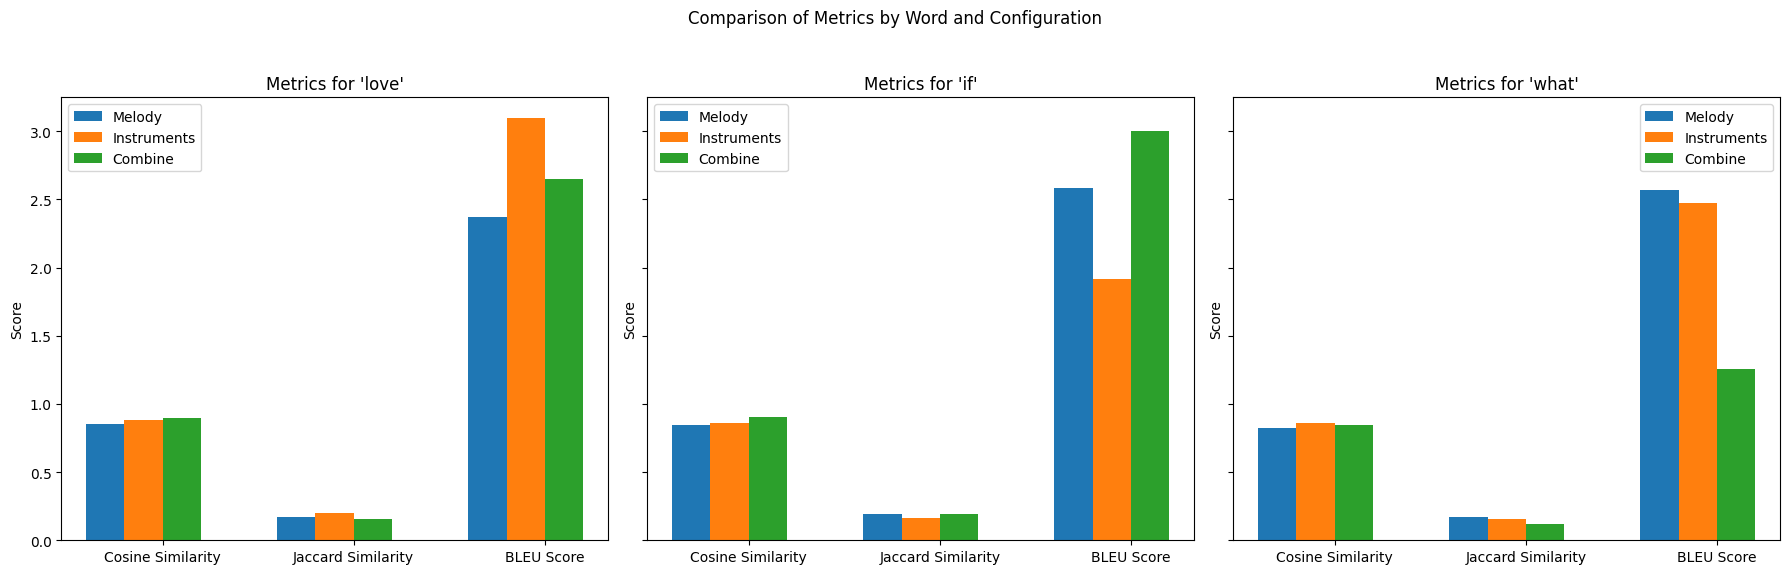

In [43]:
# Names for x-axis
metrics_names = ['Cosine Similarity', 'Jaccard Similarity', 'BLEU Score']

# List of configurations
configs_labels = ['Melody', 'Instruments', 'Combine']
configs = ['midi_features_type_melody_frames_per_word_1_lr_0.001_dropout_0.3_num_layers_2_weight_of_lines_0.01', 'midi_features_type_instruments_frames_per_word_1_lr_0.001_dropout_0.3_num_layers_2_weight_of_lines_0.01', 'midi_features_type_combine_frames_per_word_1_lr_0.001_dropout_0.3_num_layers_2_weight_of_lines_0.01']


# Initialize plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
fig.suptitle('Comparison of Metrics by Word and Configuration')

# Plotting loop
for i, (word, ax) in enumerate(zip(initial_words, axes)):
    # Each metric gets its own subplot
    ax.set_title(f"Metrics for '{word}'")
    ax.set_xticks(np.arange(len(metrics_names)))
    ax.set_xticklabels(metrics_names)
    ax.set_ylabel('Score')

    # Collect data for each configuration
    for j, config in enumerate(configs):
        scores = results[config][word]
        x_offsets = np.arange(len(metrics_names)) + 0.2 * (j - 1.5)  # Offset for bar placement
        ax.bar(x_offsets, scores, width=0.2, label=configs_labels[j])

    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()